In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """
    borders = max(a, b) + 1
    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)
    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))
    # Get domain dimensions
    bound = vel.shape
    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v
        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]
        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1
            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0
                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                    i1, i2 = int(i1[0]), int(i2[0])
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])
    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

In [4]:
def find_root(x, y):

    roots = np.where(np.diff(np.sign(y)))[0]

    if roots.size == 0:
    
        coefficients = np.polyfit(x, y, 3)
        polynomial = np.poly1d(coefficients)
        roots = np.roots(polynomial)

        R = np.abs(x[len(x)//2] - roots)
        root = roots[np.argmin(R)]

    elif roots.size == 1:
        root = np.interp(0, x, y)
        
    else:
        R = np.abs(x[len(x)//2] - roots)
        root = roots[np.argmin(R)]

    return root

def tang_at_root(x, y, root_x):
    if root_x >= np.min(x) and root_x <= np.max(x):

        dydx = np.gradient(y, x)
        slope_at_root = np.interp(root_x, x, dydx)
        intercept = np.interp(root_x, x, y) - slope_at_root * root_x
        return slope_at_root, intercept
    
    else:

        coeffs = np.polyfit(x, y, 3)
        poly_derivative = np.polyder(coeffs)
        slope_at_root = np.polyval(poly_derivative, root_x)
        y_at_root = np.polyval(coeffs, root_x)
        intercept = y_at_root - slope_at_root * root_x
        return slope_at_root, intercept



# def find_root(x, y):
#     coefficients = np.polyfit(x, y, 3)
#     polynomial = np.poly1d(coefficients)
#     roots = np.roots(polynomial)
#     R = np.abs(x[len(x)//2] - roots)
#     root = roots[np.argmin(R)]

#     return root

# def tang_at_root(x, y, root_x):
#     coeffs = np.polyfit(x, y, 3)
#     poly_derivative = np.polyder(coeffs)
#     slope_at_root = np.polyval(poly_derivative, root_x)
#     y_at_root = np.polyval(coeffs, root_x)
#     intercept = y_at_root - slope_at_root * root_x
    
#     return slope_at_root, intercept














        

In [31]:
def vis(eddy, t, depth_lvl):

    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x']/1000, sample_data[eddy][f'T{t}']['y']/1000
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0

    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
    neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 2] == var]
    
    if len(neddy[:, 1]) > 1:
        R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
        neddy = neddy[R == np.nanmin(R)]
    
    nxc, nyc = neddy[0, 1] + 1*dx, neddy[0, 0] + 1*dx  # intentionally off!!!!!!
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]

    r = 5
    
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    
    root_x = find_root(xx, v1)
    A1, A0 = tang_at_root(xx, u1, root_x)
    B1, B0 = tang_at_root(xx, v1, root_x)
    p_u1 = A1*xx + A0
    p_v1 = B1*xx + B0

    root_y = find_root(yy, u2)
    C1, C0 = tang_at_root(yy, u2, root_y)
    D1, D0 = tang_at_root(yy, v2, root_y)
    p_u2 = C1*yy + C0
    p_v2 = D1*yy + D0

    r2A = np.inf if np.min(np.abs(u1)) == 0 else 1 / np.min(np.abs(u1))
    r2B = np.inf if np.min(np.abs(v1)) == 0 else 1 / np.min(np.abs(v1))
    r2C = np.inf if np.min(np.abs(u2)) == 0 else 1 / np.min(np.abs(u2))
    r2D = np.inf if np.min(np.abs(v2)) == 0 else 1 / np.min(np.abs(v2))

    axs[0].plot(xx, p_u1, 'b--')#, color=colours[i])
    axs[0].plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
    axs[0].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    axs[1].plot(xx, p_v1, 'k--',)#, color=colours[i+1])
    axs[1].plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
    axs[1].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

    axs[2].plot(yy, p_u2, 'b--')#, color=colours[i])
    axs[2].plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
    axs[2].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    axs[3].plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
    axs[3].plot(yy, p_v2, 'k--')#, color=colours[i+1])
    axs[3].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
    w = 2 * (q11 + q22)

    # Plot results
    spacing = 2
    scale = 20
    plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, scale=scale)

    plt.plot(x1, y1, 'r', zorder=1, alpha=.5)
    plt.plot(x2, y2, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X, Y, mask.T, cmap='gray', zorder=-1)
        plt.contour(X, Y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    
    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    # plt.legend()
    
    plt.axis('equal')
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    

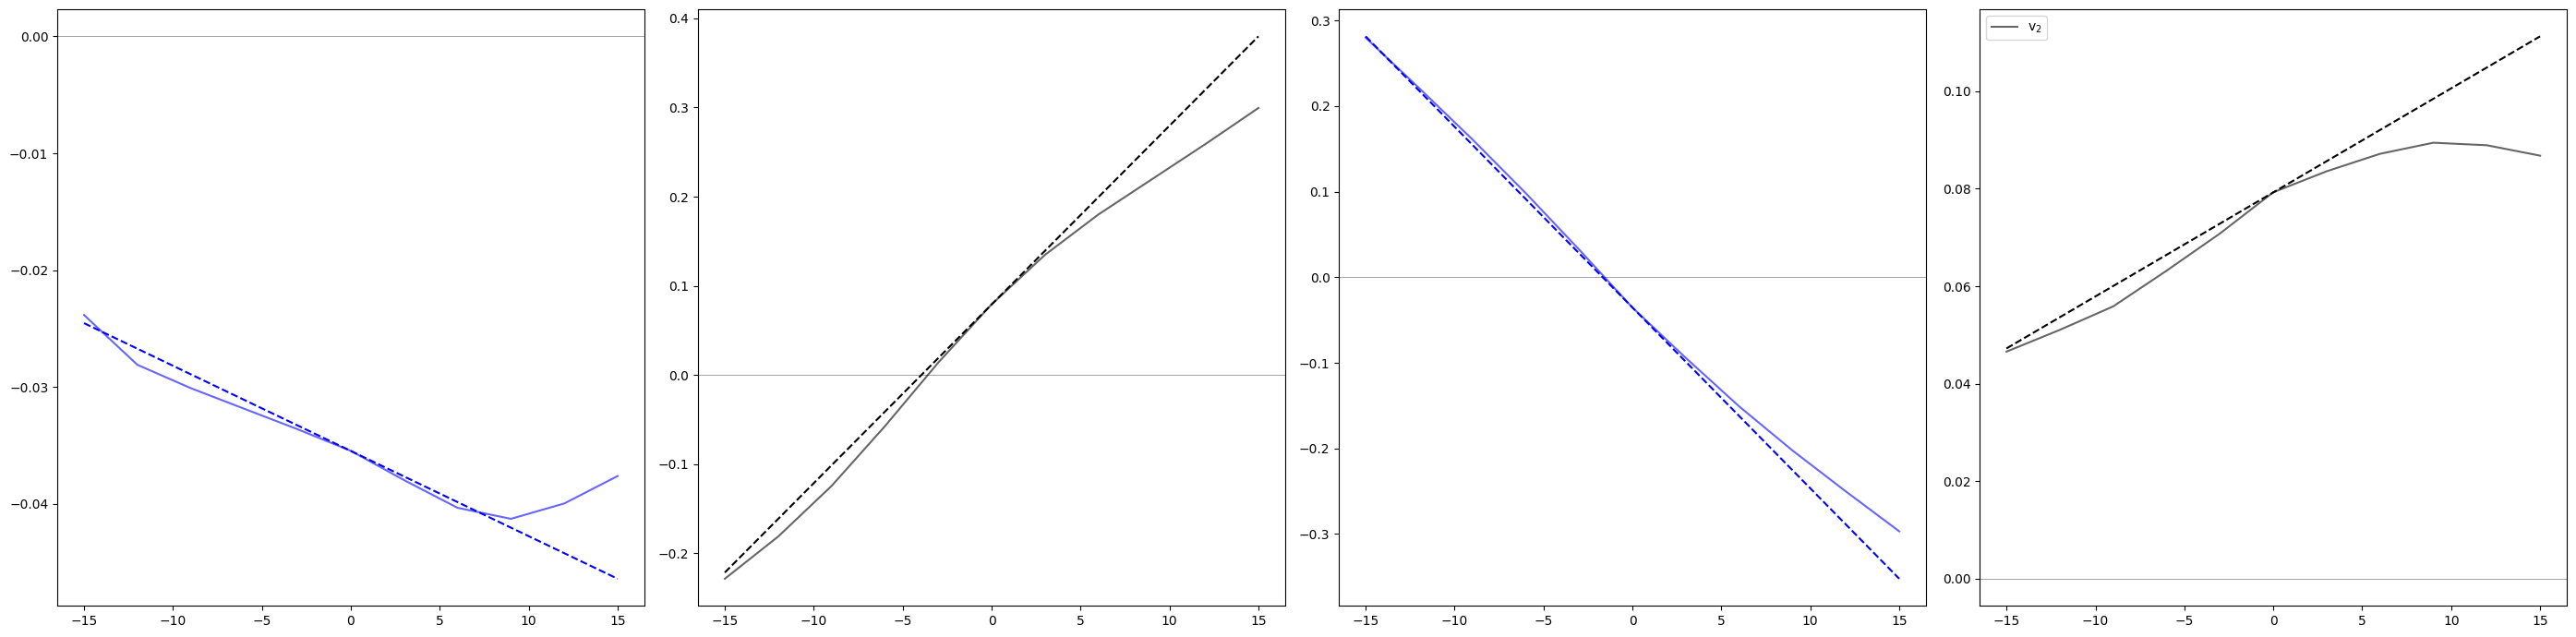

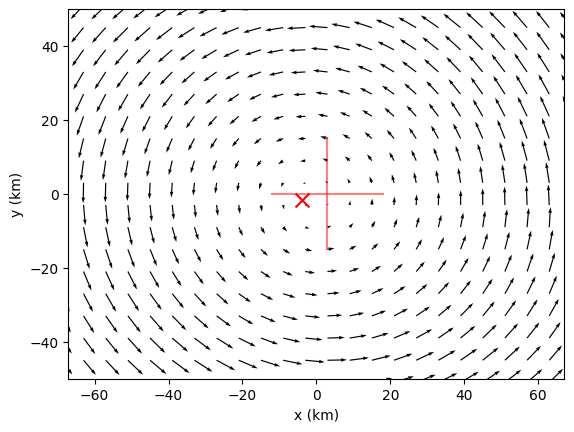

In [32]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 10

vis(eddy, t, depth_lvl)

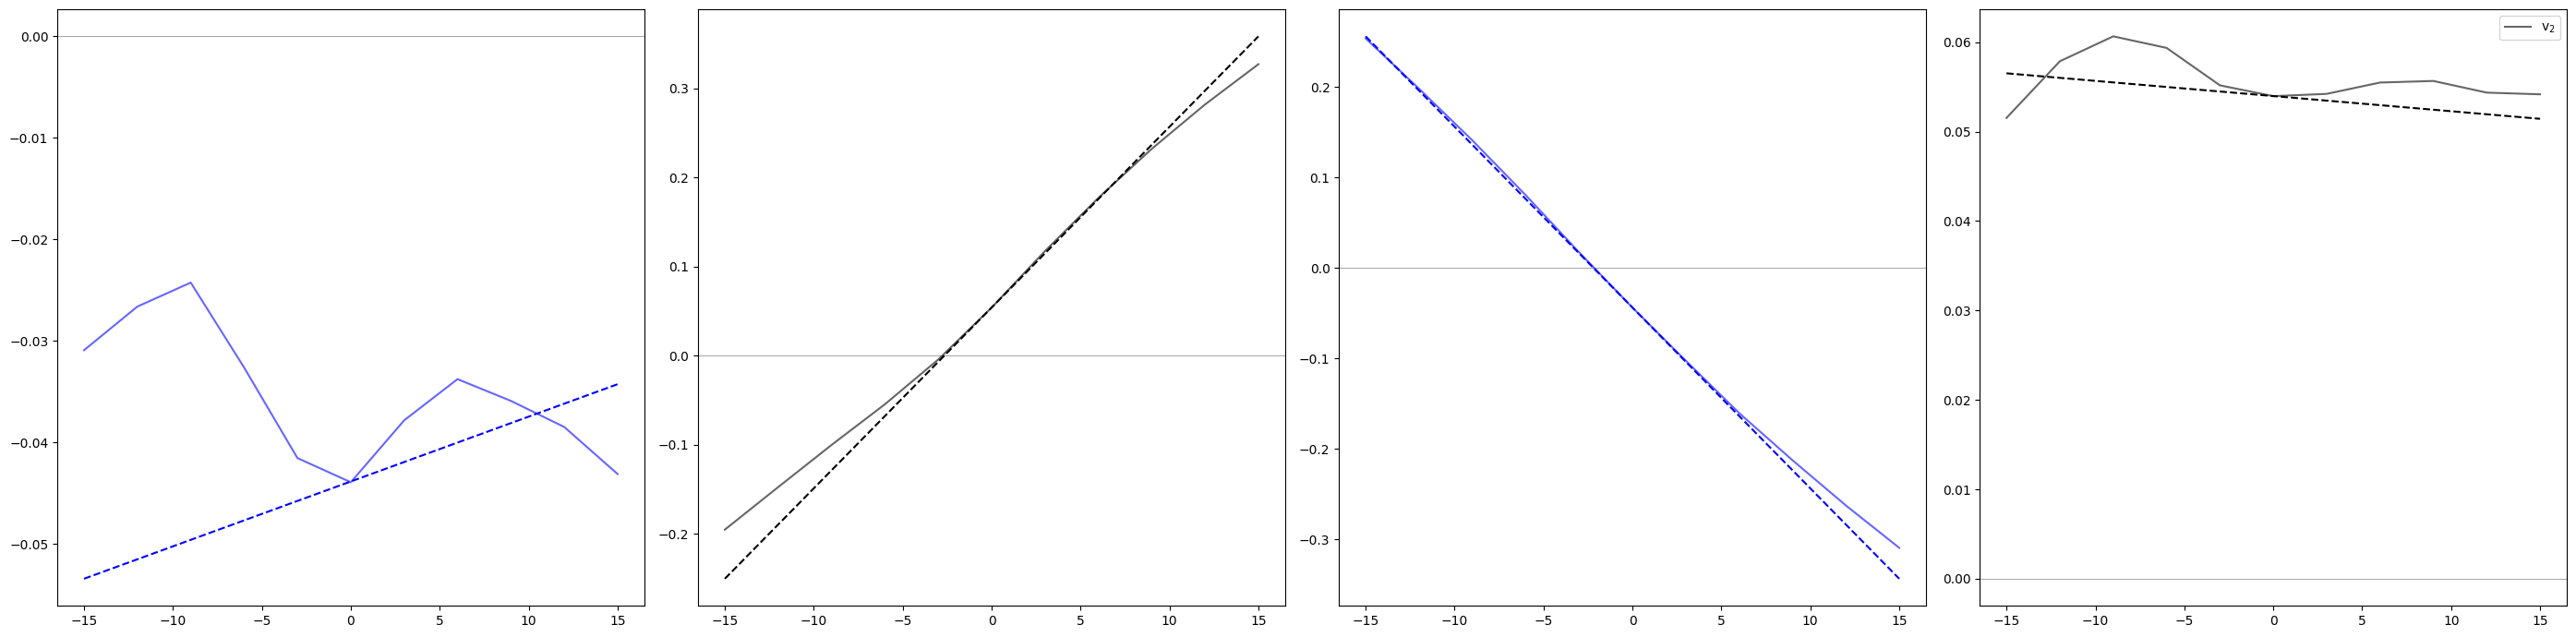

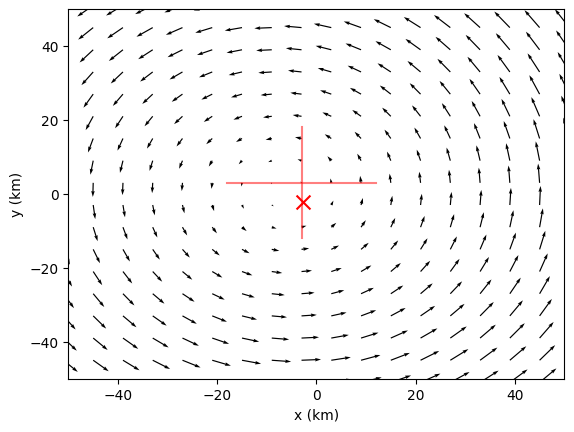

In [7]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 0

vis(eddy, t, depth_lvl)

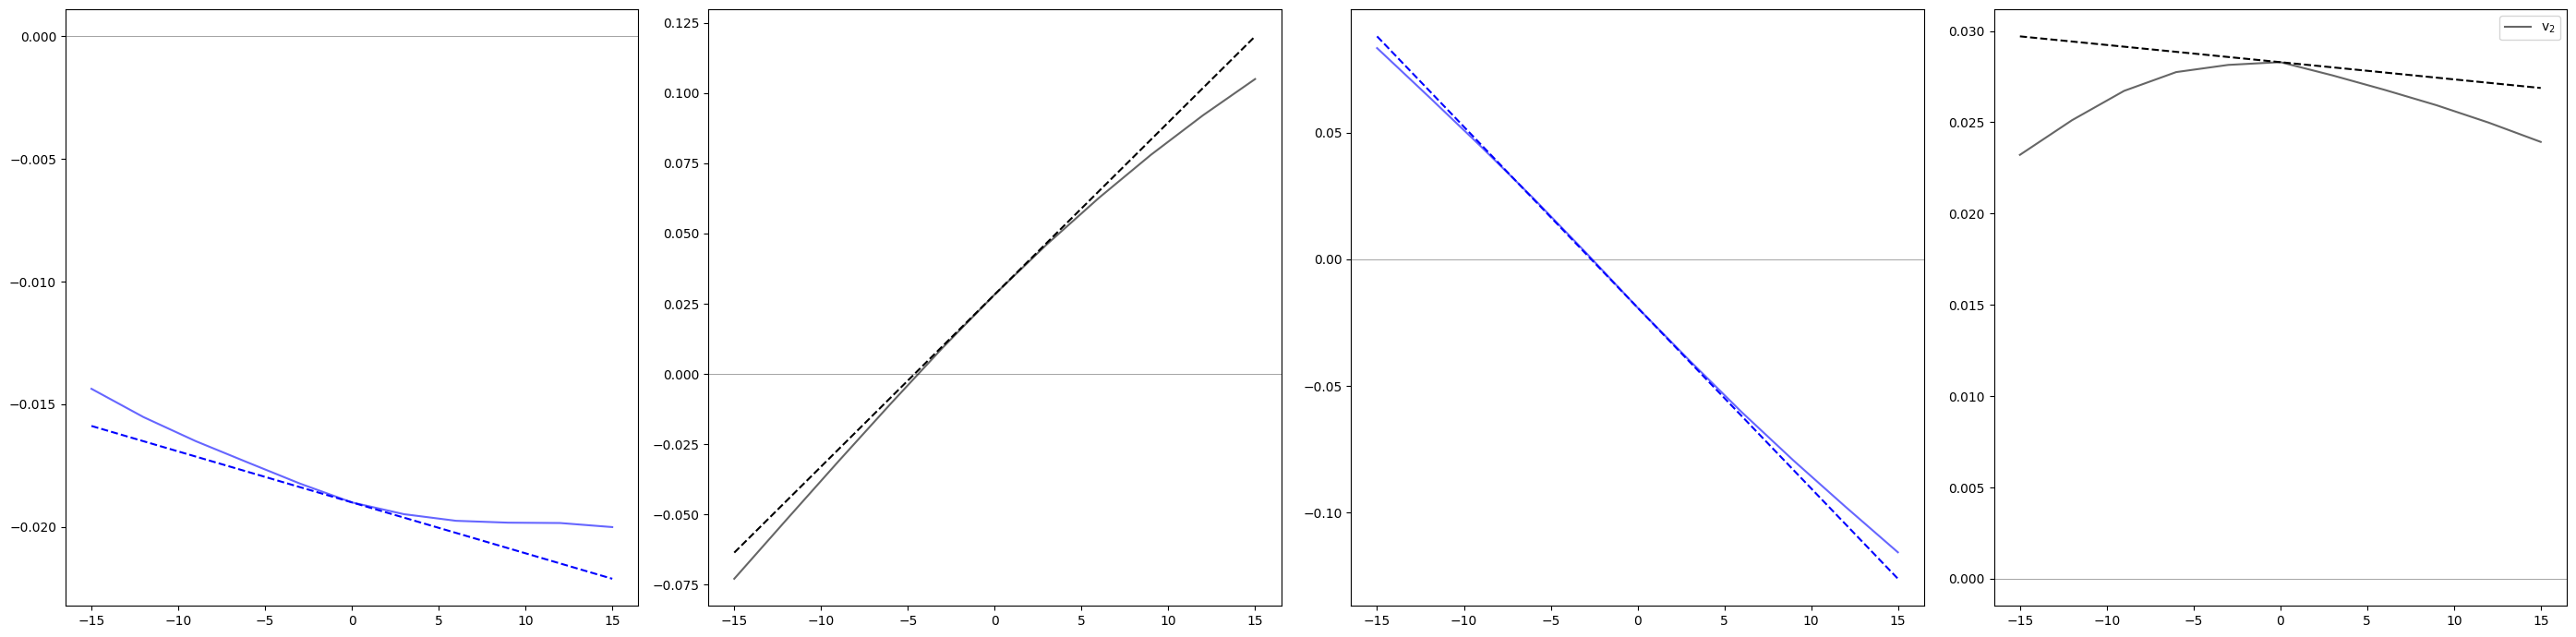

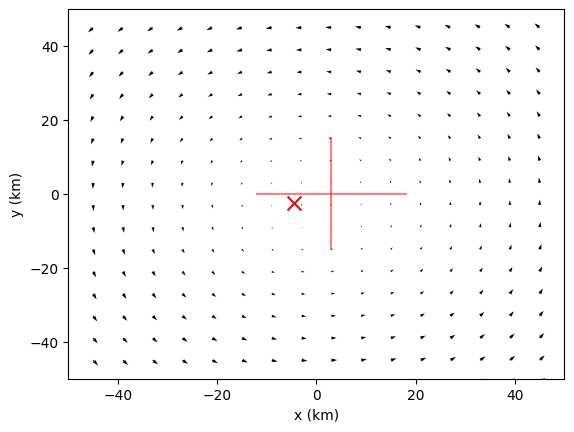

In [8]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 14, 20

vis(eddy, t, depth_lvl)

Poor tangential fits but good result

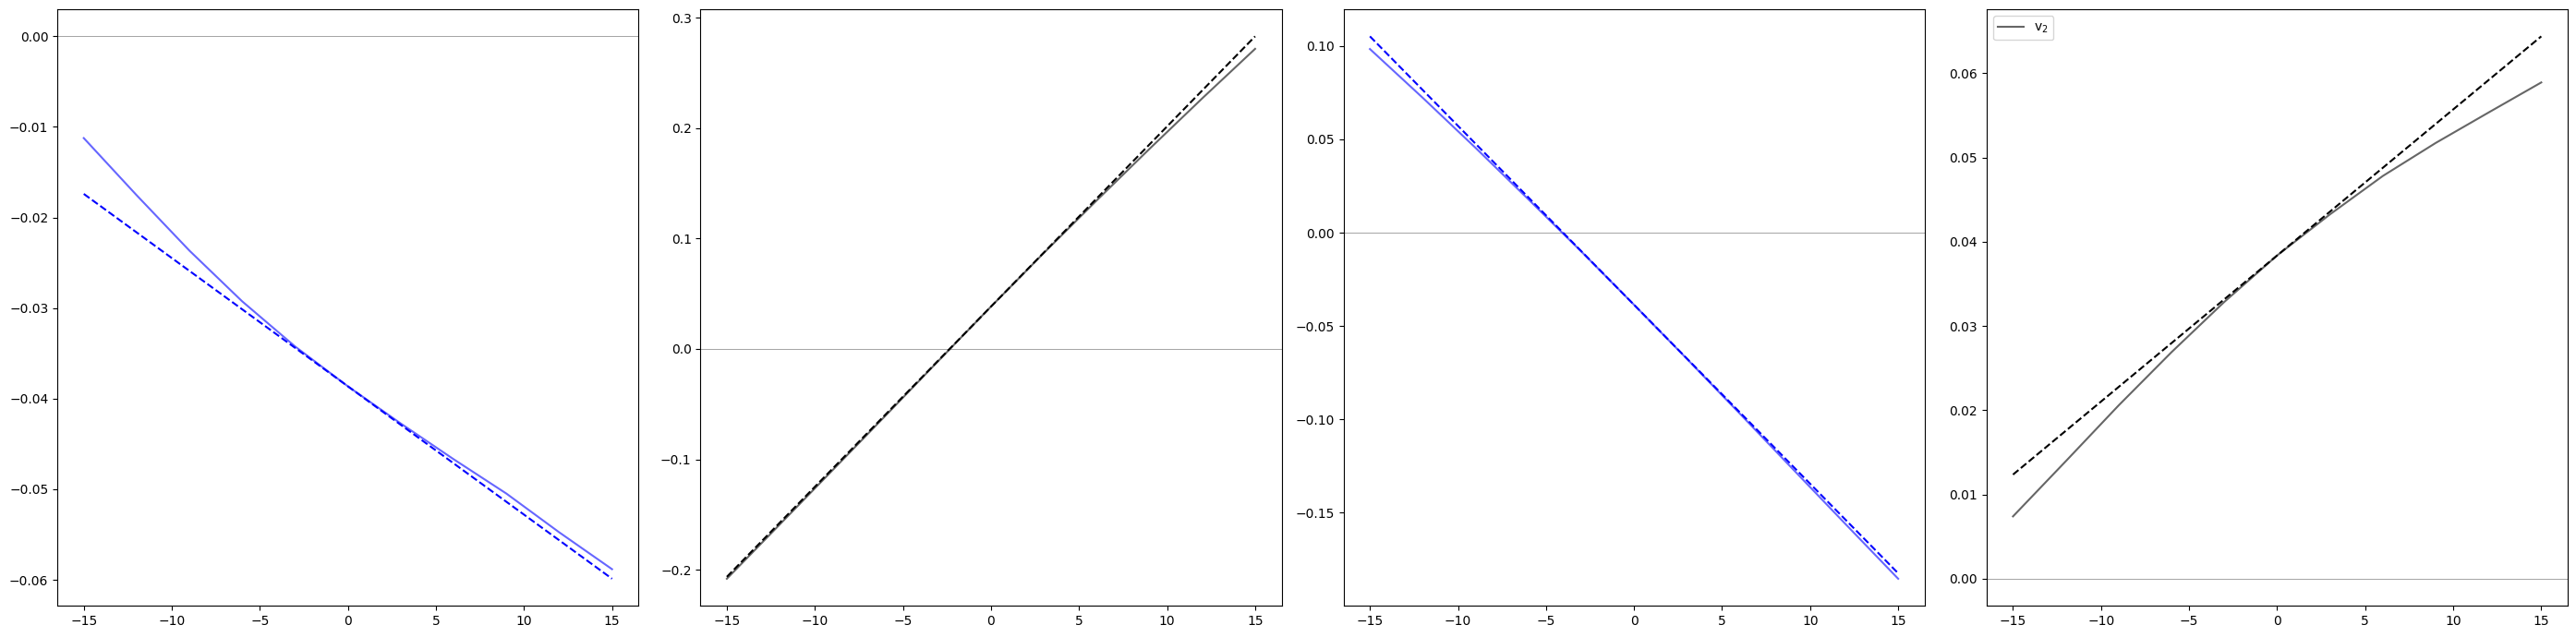

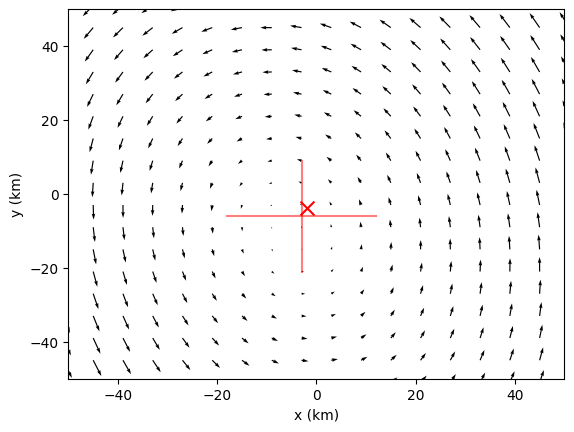

In [9]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

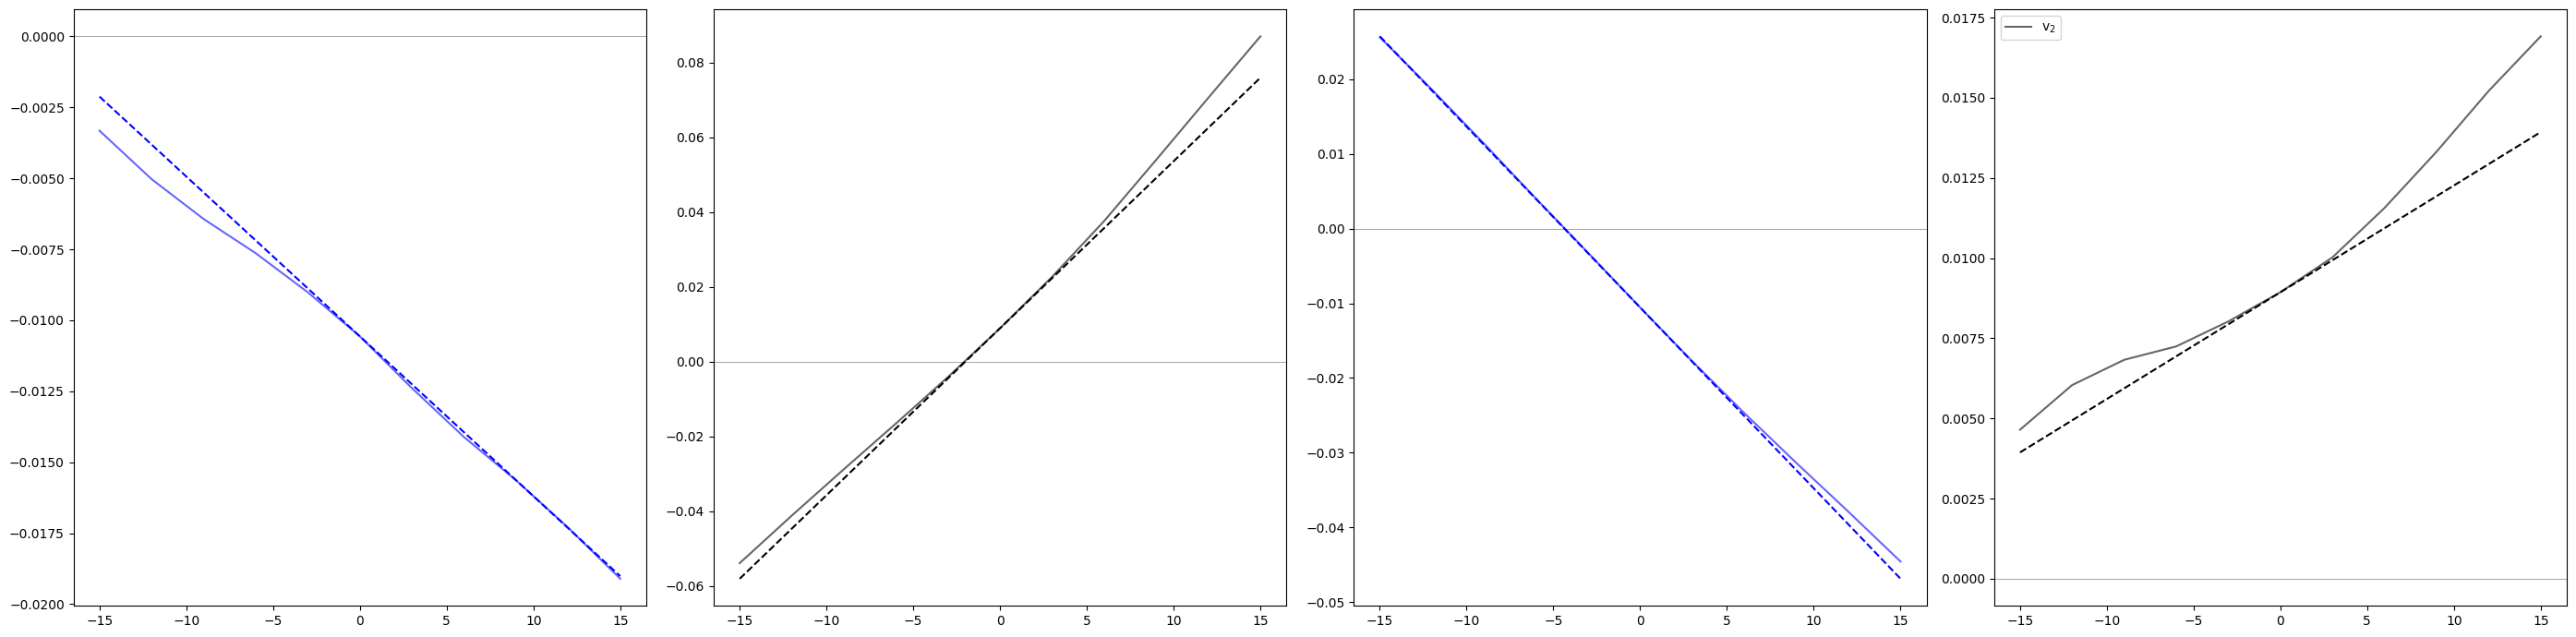

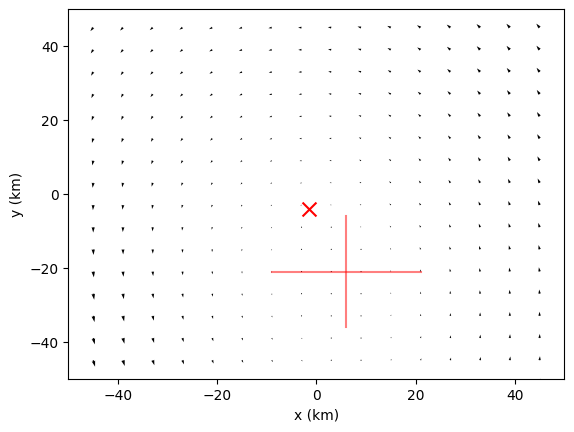

In [10]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 20

vis(eddy, t, depth_lvl)

Good tangential fits but reasonably poor result

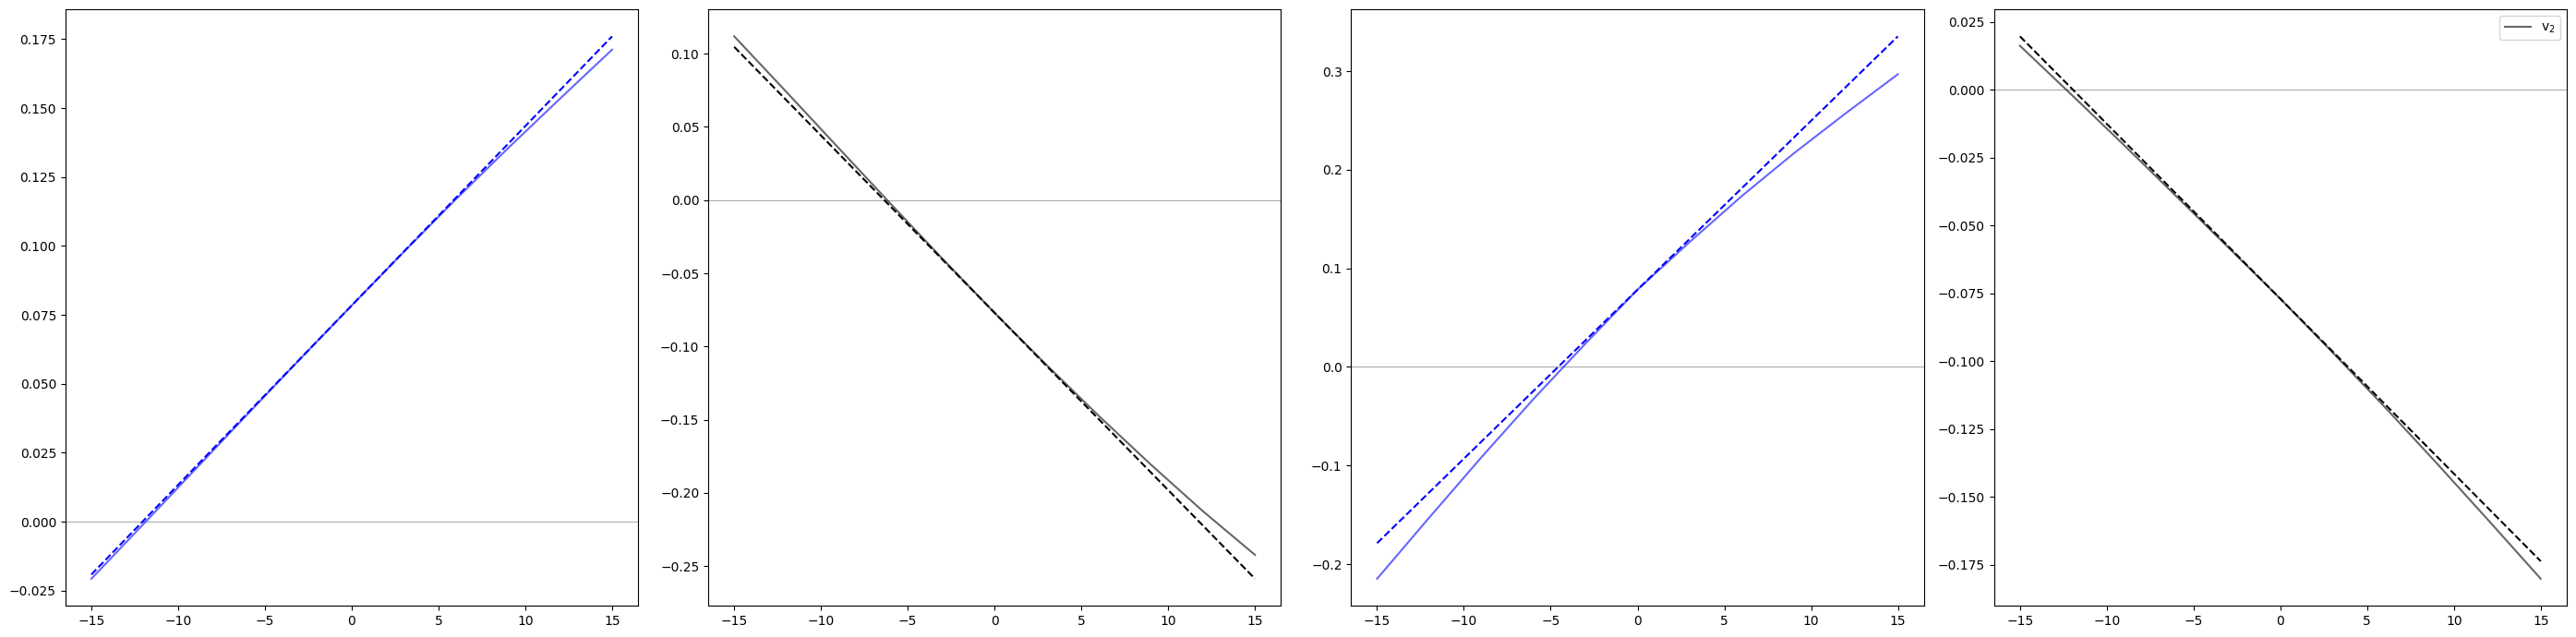

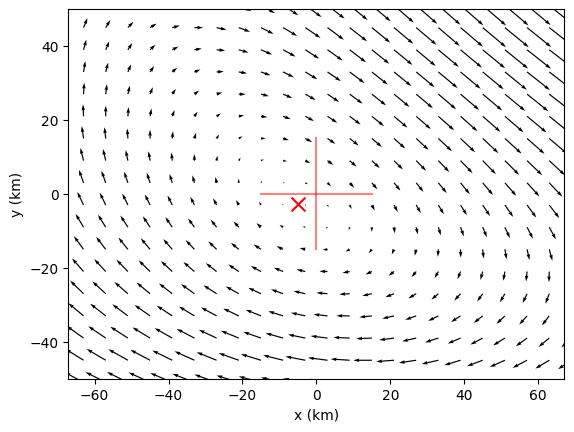

In [33]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 0, 0

vis(eddy, t, depth_lvl)

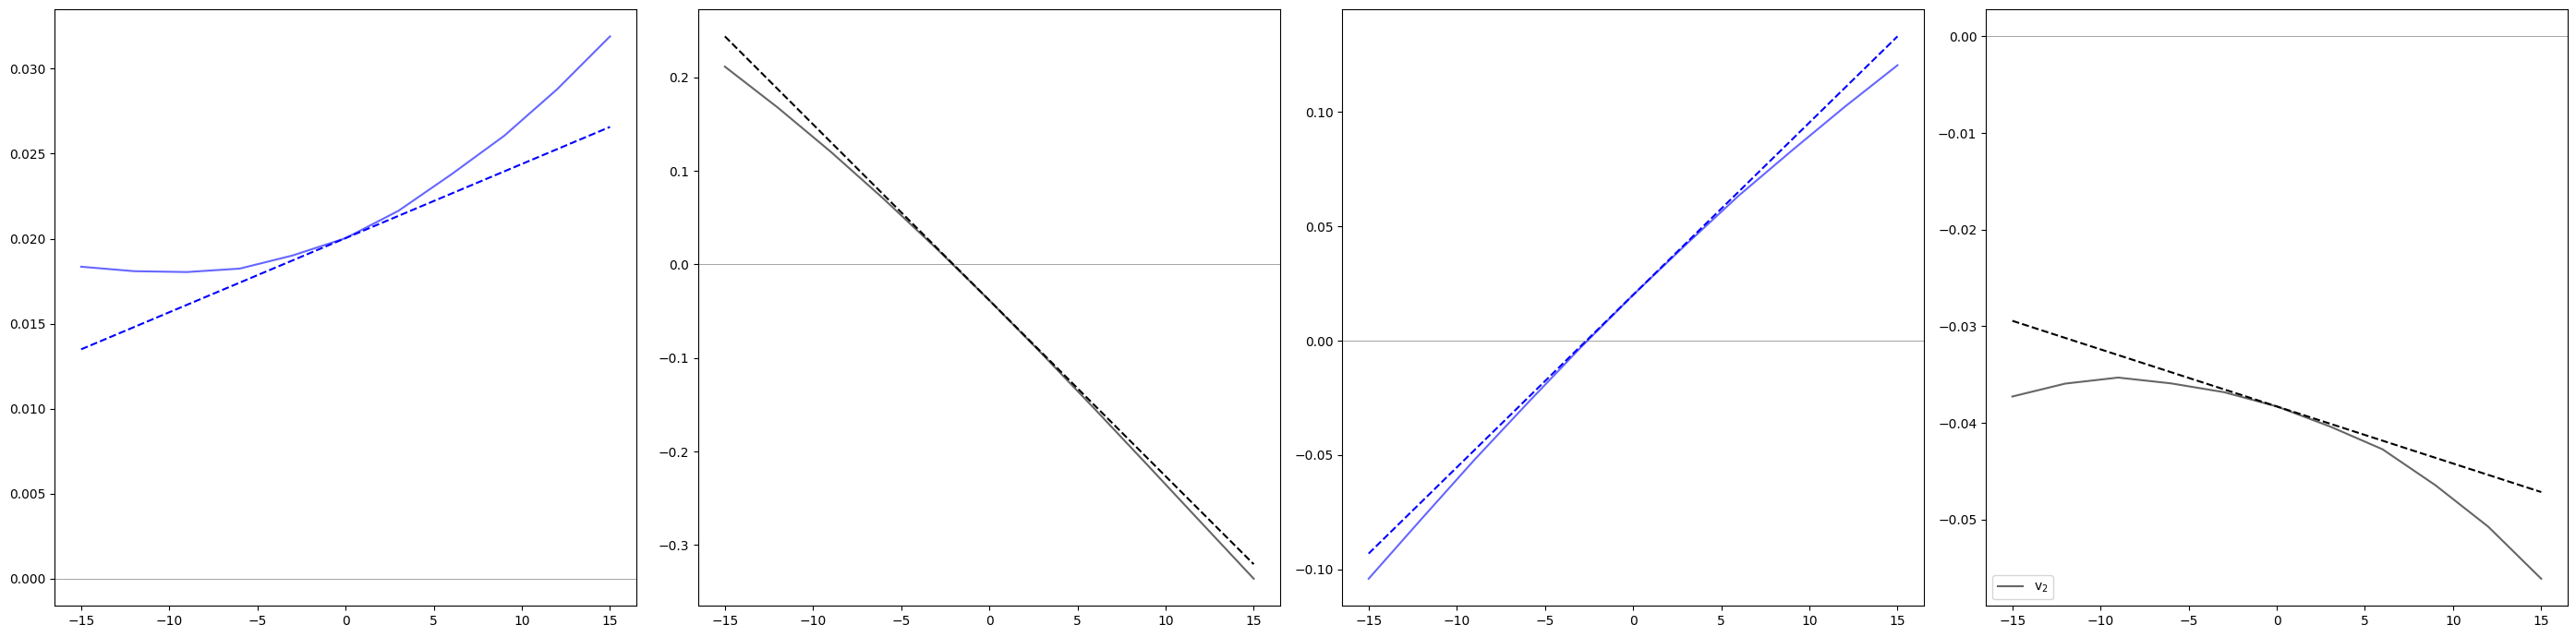

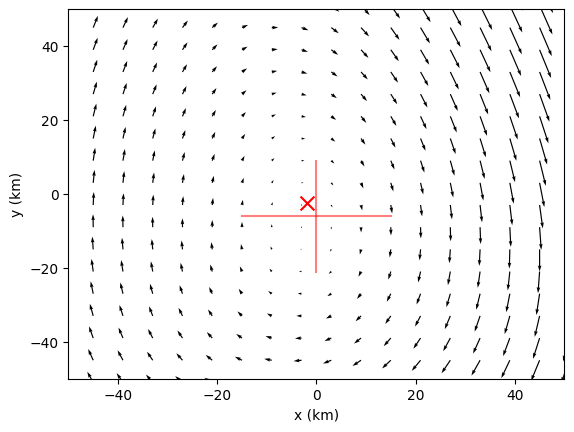

In [12]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 10, 10

vis(eddy, t, depth_lvl)

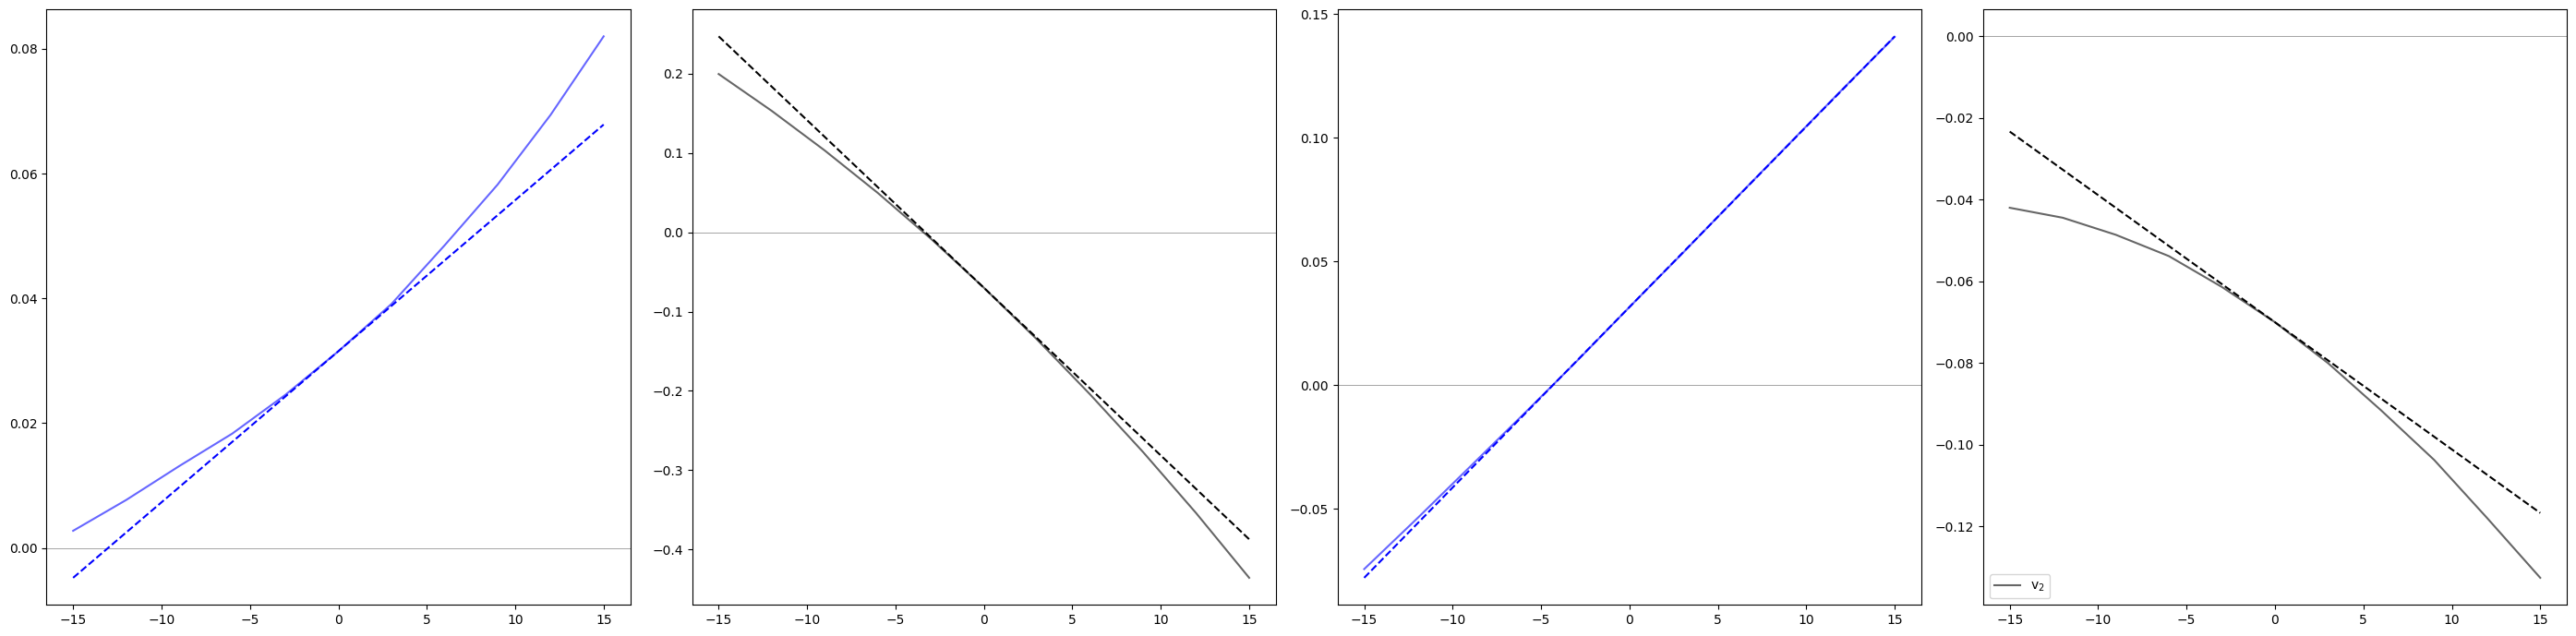

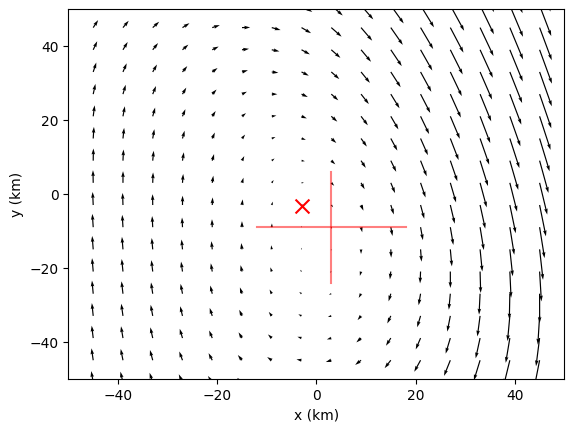

In [13]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

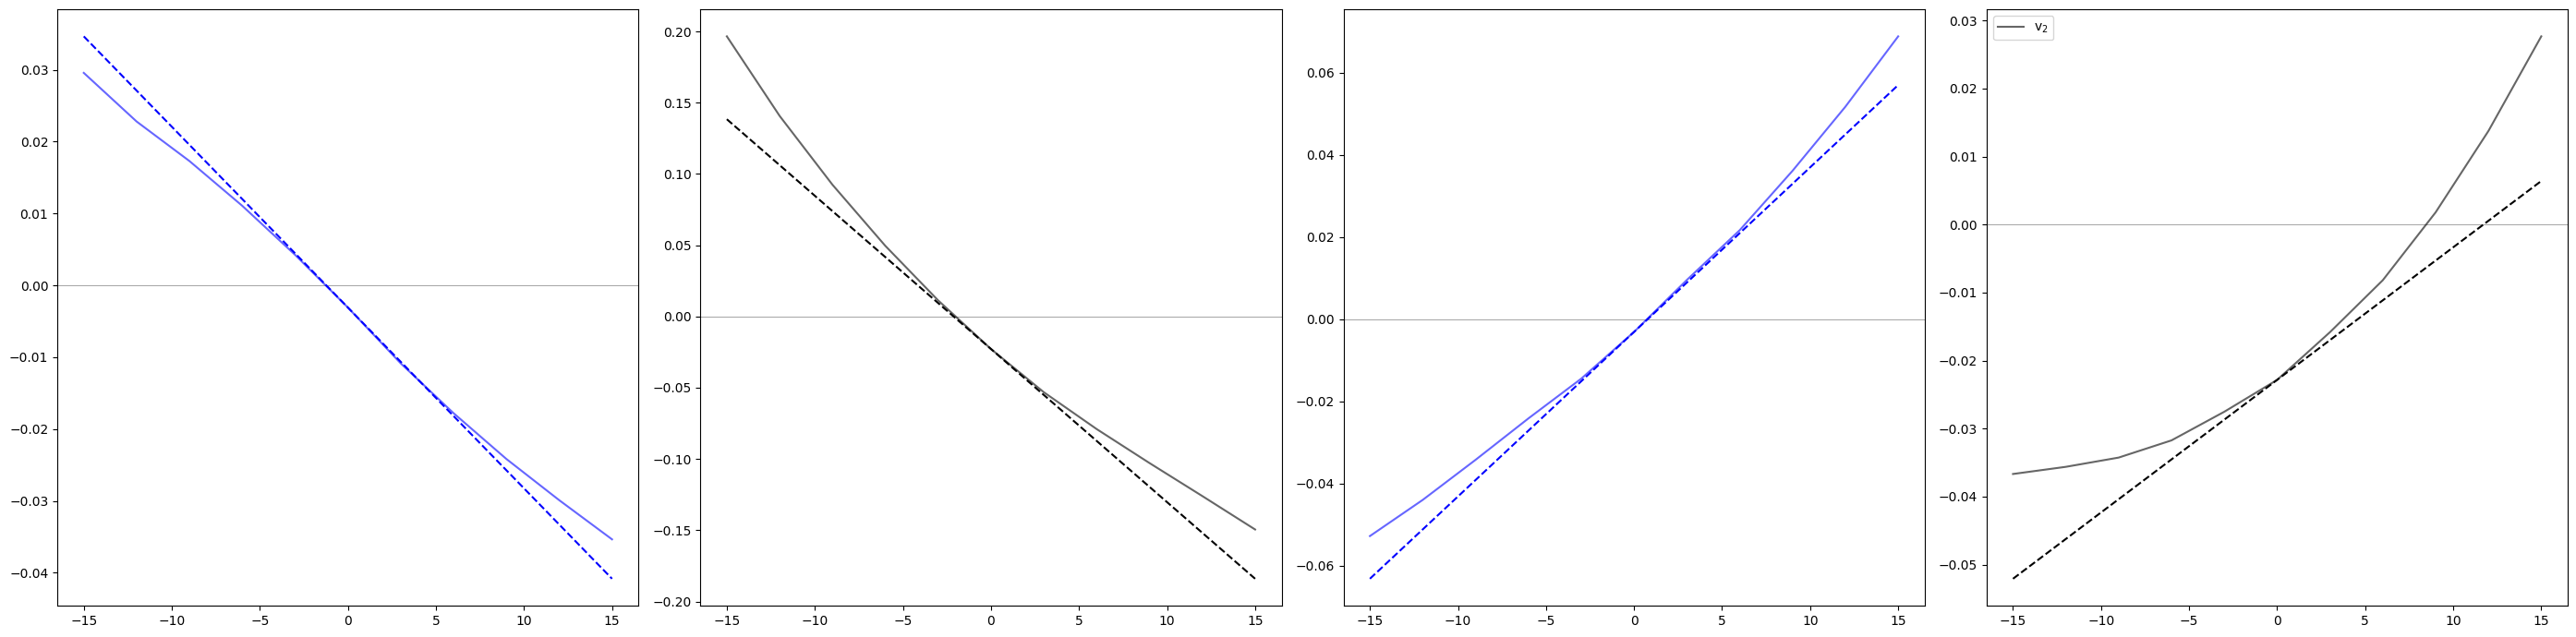

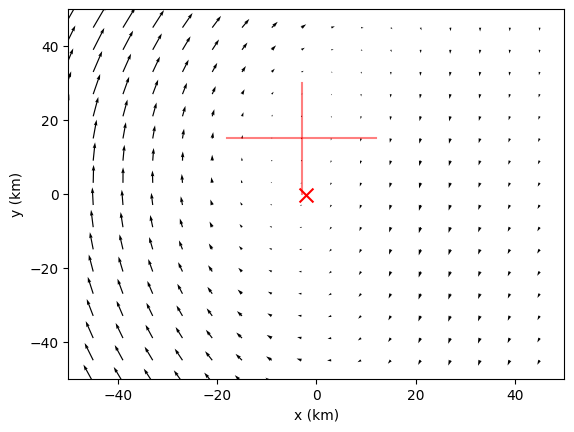

In [14]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

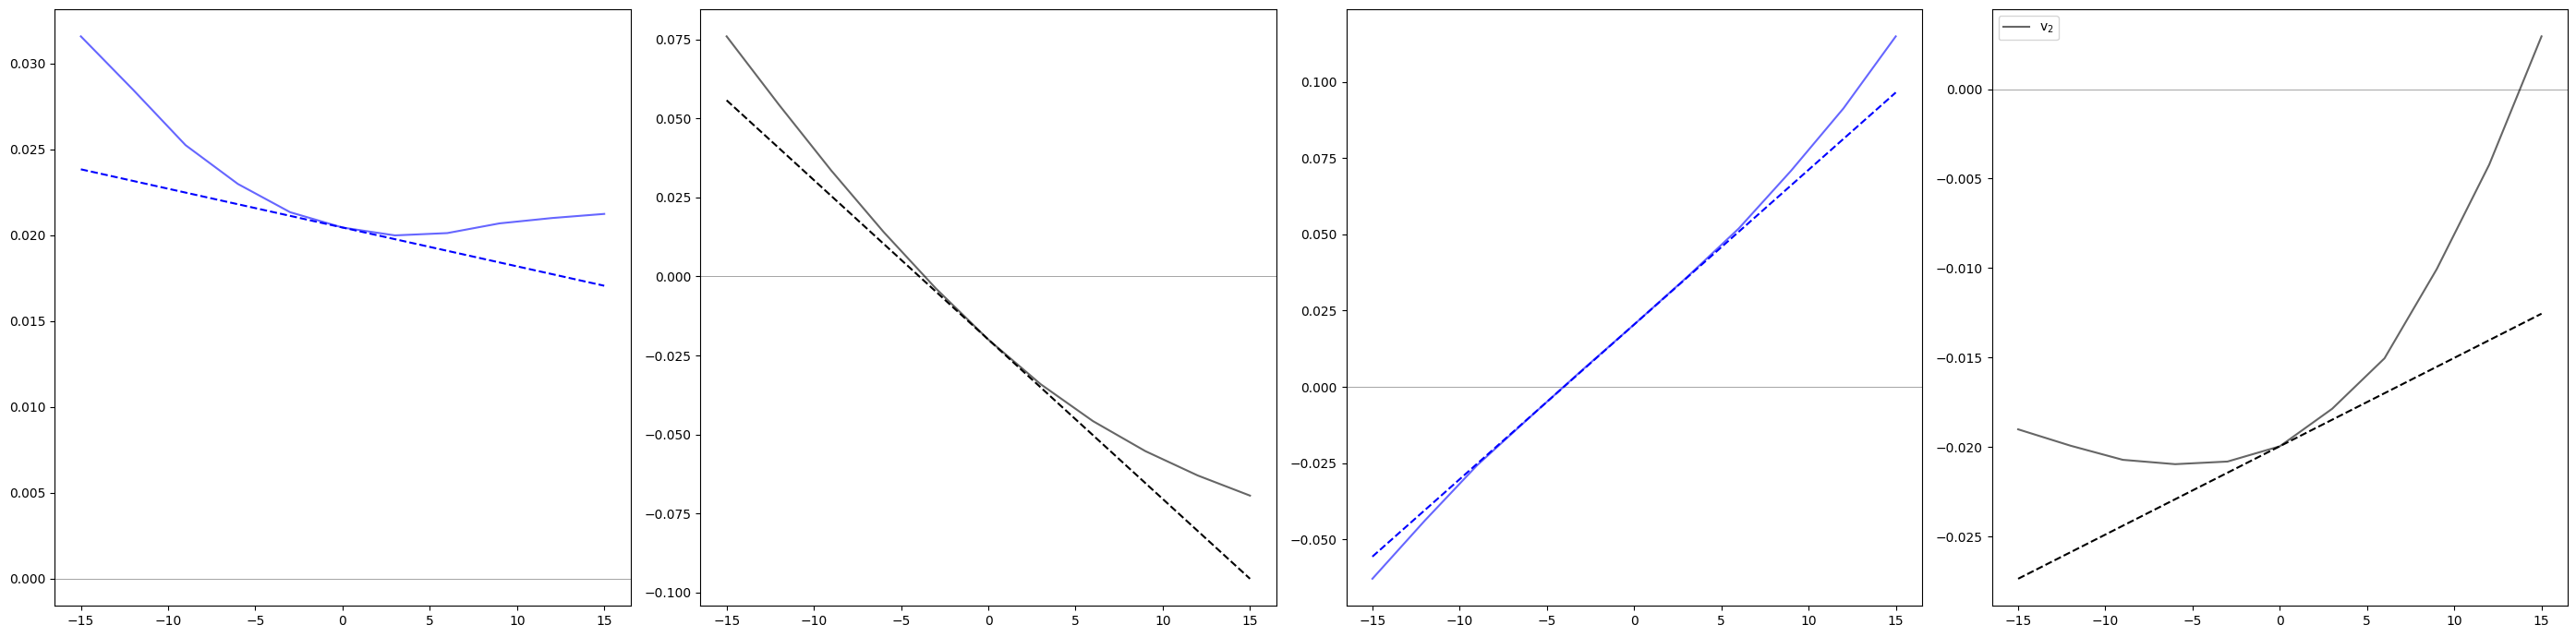

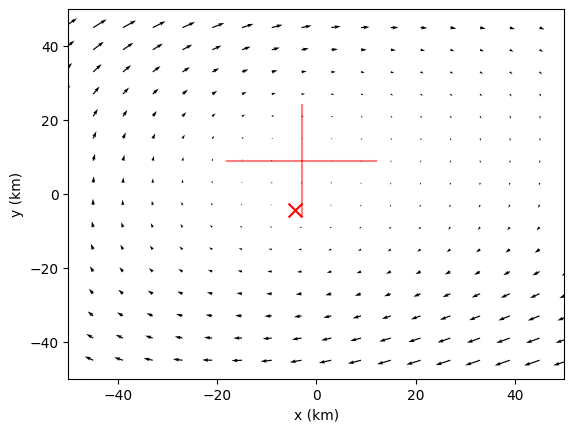

In [15]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

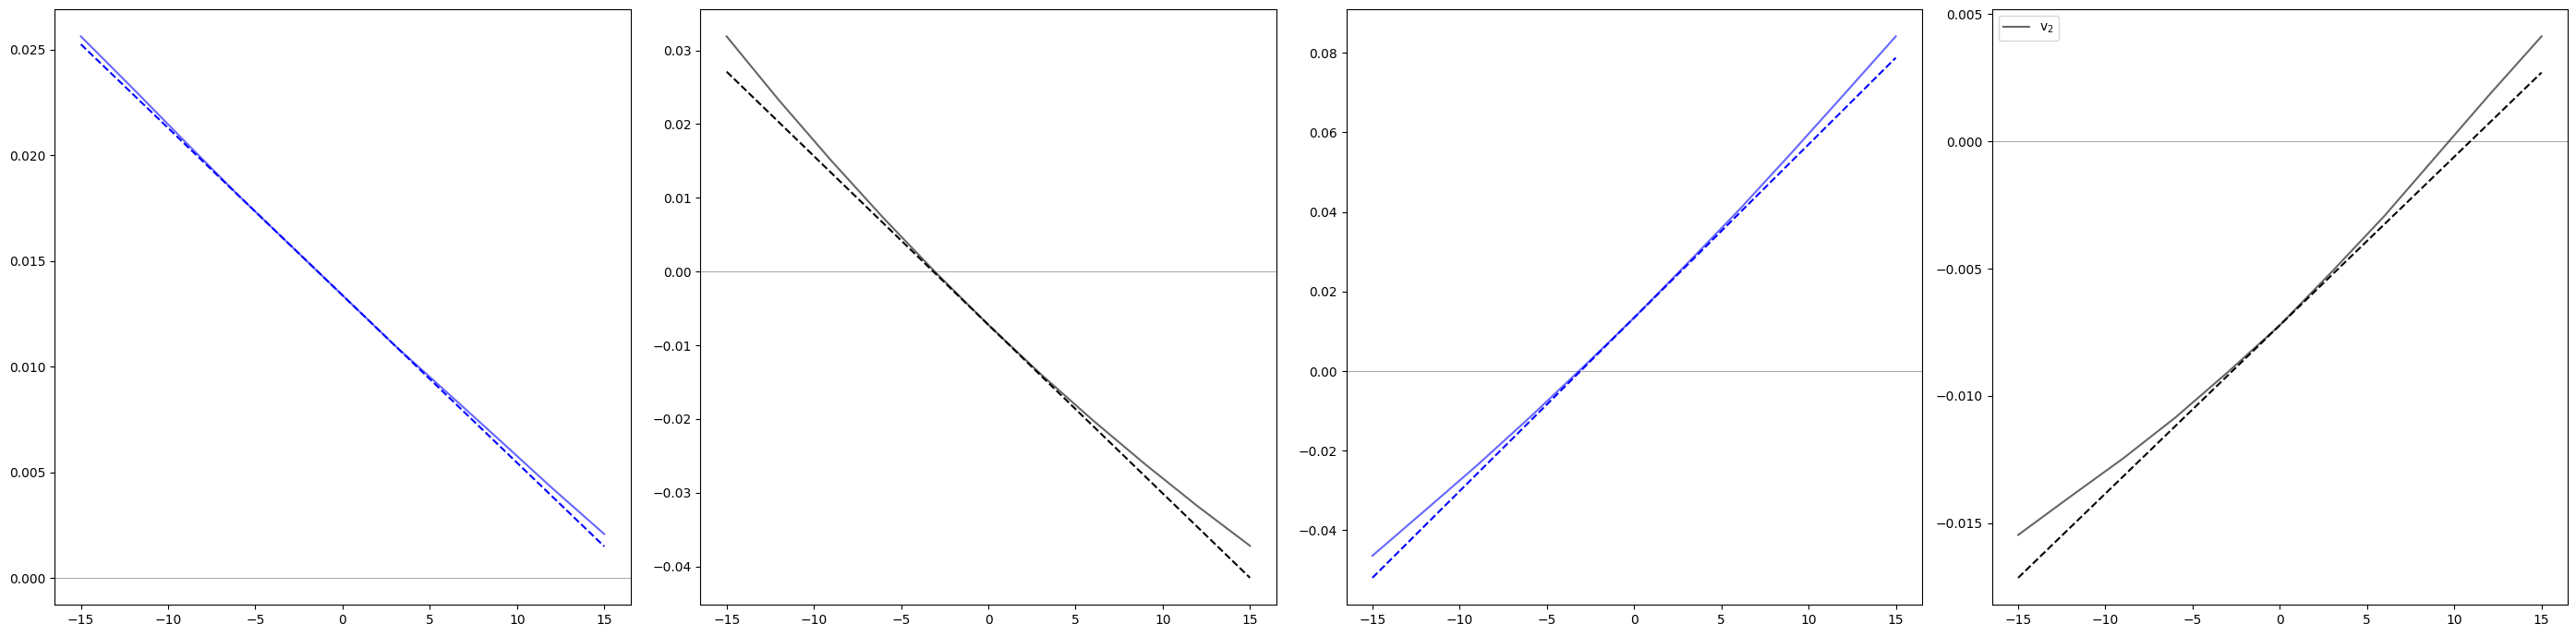

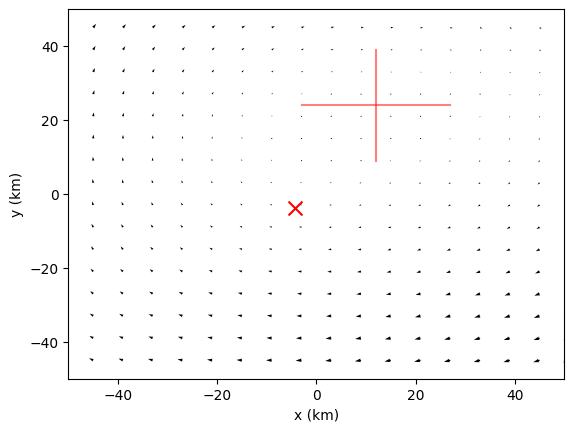

In [16]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 20

vis(eddy, t, depth_lvl)

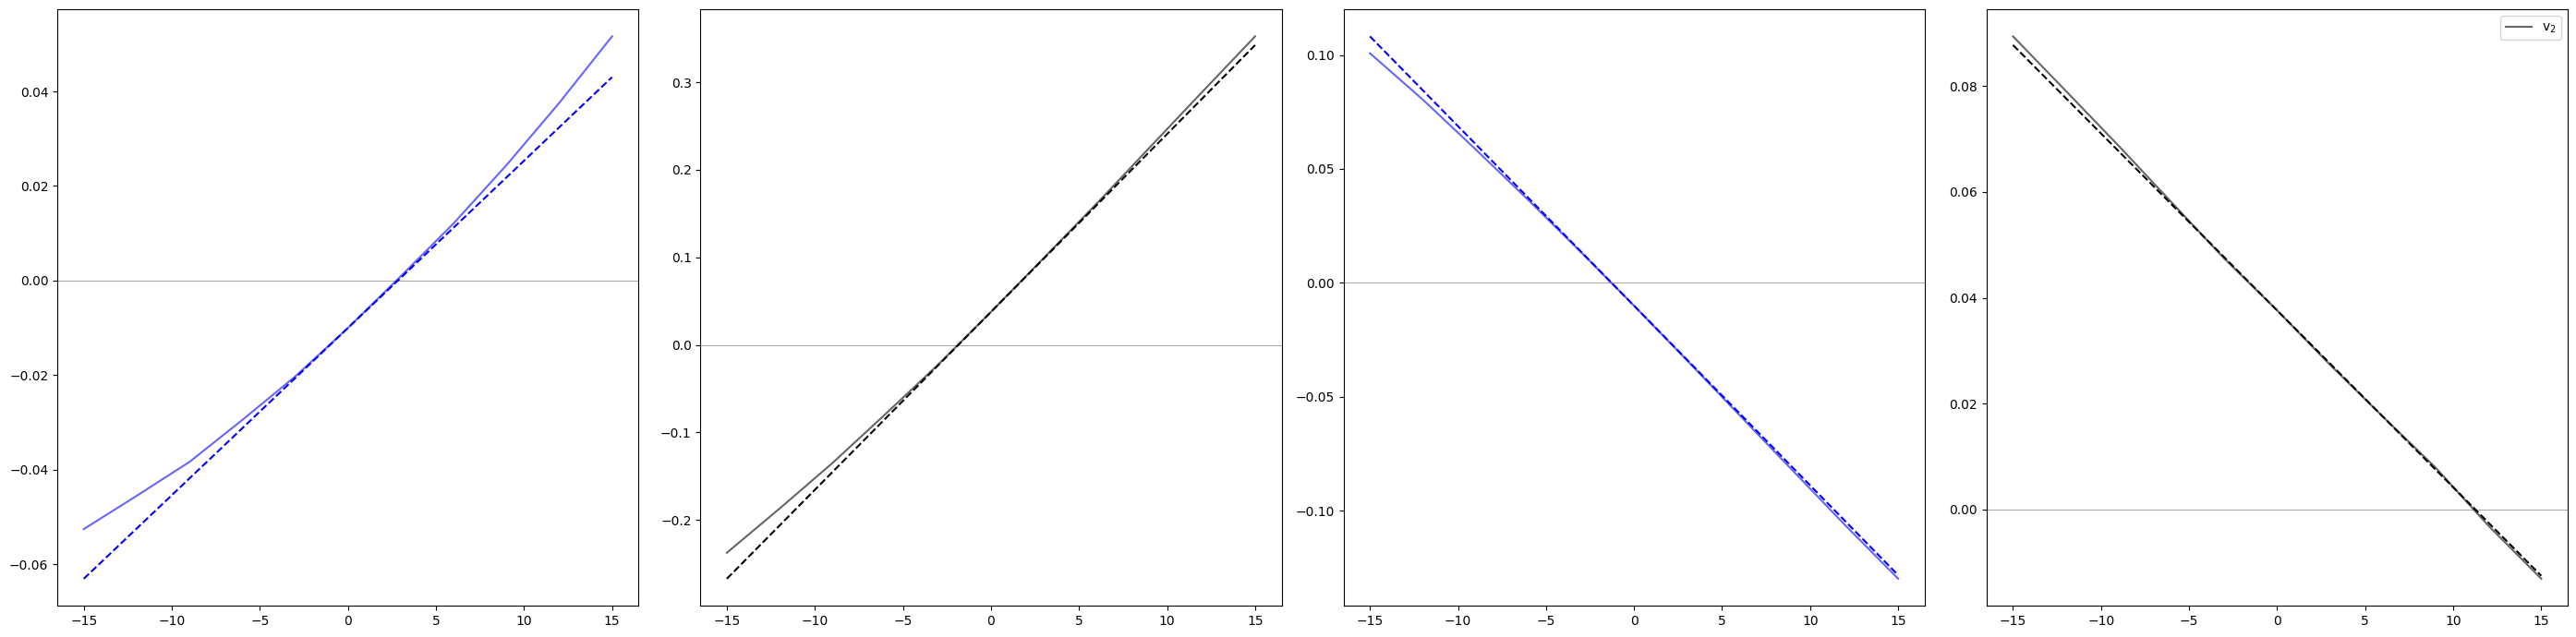

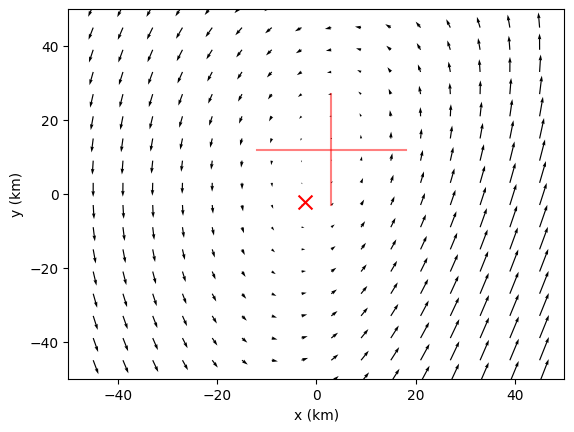

In [17]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

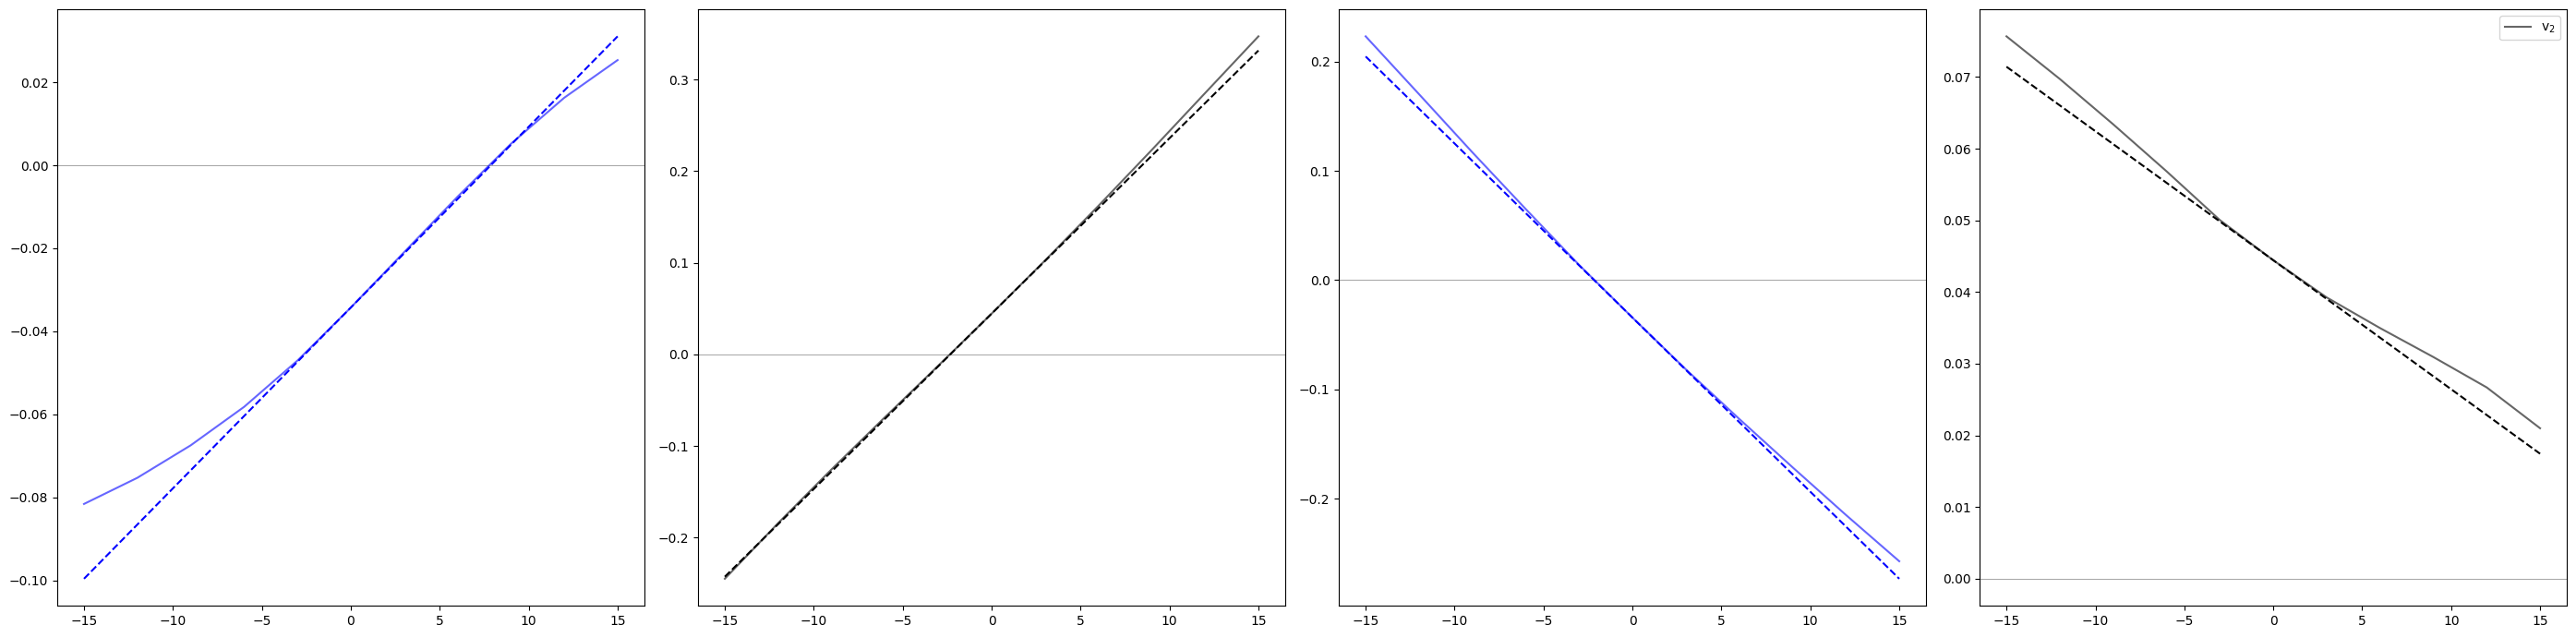

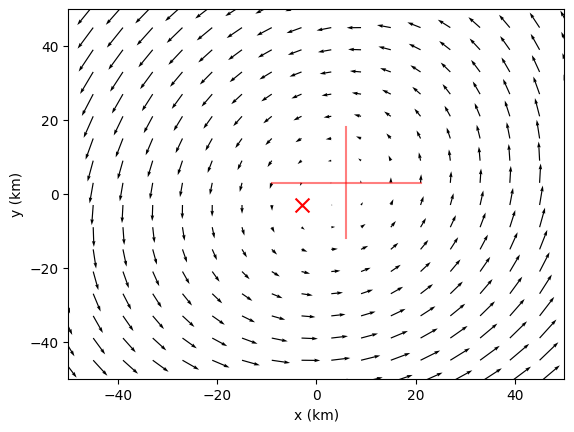

In [18]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 0, 7

vis(eddy, t, depth_lvl)

In [19]:
result_data = pd.DataFrame(columns=['Eddy', 'Day', 'z', 'nic', 'njc', 'nxc', 'nyc', 'xc', 'yc', 'Depth', 'Vort', 'r1', 'r2', 'r3', 'r4'])

plot_data = {}

for eddy in the_frontier_eddies:

    plot_data[eddy] = {}
    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x']/1000, sample_data[eddy][f'T{t}']['y']/1000
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
        neddy = neddy[neddy[:, 2] == var]
        
        if len(neddy[:, 1]) > 1:
            R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
            neddy = neddy[R == np.nanmin(R)]
        elif len(neddy[:, 1]) == 0:
            break
        
        nxc, nyc = neddy[0, 1], neddy[0, 0]
        nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]

        r = 5
        
        u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
        x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
        xx = x1 - X.T[nic, njc]
    
        u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
        x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
        yy = y2 - Y.T[nic, njc]
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0
    
        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        r2A = np.inf if np.min(np.abs(u1)) == 0 else 1 / np.min(np.abs(u1))
        r2B = np.inf if np.min(np.abs(v1)) == 0 else 1 / np.min(np.abs(v1))
        r2C = np.inf if np.min(np.abs(u2)) == 0 else 1 / np.min(np.abs(u2))
        r2D = np.inf if np.min(np.abs(v2)) == 0 else 1 / np.min(np.abs(v2))
    
        alpha = A0 if r2A > r2C else C0
        beta = B0 if r2B > r2D else D0
        gamma = A1 if r2A > r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        VORT_THRESH = 0.003
        R = np.hypot(xc - xc_pre, yc - yc_pre)
        if np.abs(w) > VORT_THRESH and R < 100:
            result_data.loc[len(result_data)] = {
                'Eddy': eddy,
                'Day': t,
                'z': depth_lvl,
                'nic': nic,
                'njc': njc,
                'nxc': nxc,
                'nyc': nyc,
                'xc': xc,
                'yc': yc,
                'Depth': z_r[150,150,depth_lvl],
                'Vort': w,
            }
            xc_pre, yc_pre = xc, yc
            plot_data[eddy][f'x{depth_lvl}'] = xx
            plot_data[eddy][f'y{depth_lvl}'] = yy
            plot_data[eddy][f'u1_{depth_lvl}'] = u1
            plot_data[eddy][f'u2_{depth_lvl}'] = u2
            plot_data[eddy][f'v1_{depth_lvl}'] = v1
            plot_data[eddy][f'v2_{depth_lvl}'] = v2
        else:
            break

In [20]:
result_data

Eddy  Day   z  nic  njc   nxc   nyc        xc        yc        Depth  \
0    Eddy790    0   0   51   49   6.0   0.0  1.164294 -0.925069    -1.783320   
1    Eddy790    0   1   51   49   6.0   0.0  0.386914  0.156534    -5.879627   
2    Eddy790    0   2   51   49   6.0   0.0 -0.167011  0.637369   -10.725783   
3    Eddy790    0   3   51   49   6.0   0.0 -0.766120  0.911219   -16.383097   
4    Eddy790    0   4   50   49   3.0   0.0  1.550957  0.563185   -22.925581   
..       ...  ...  ..  ...  ...   ...   ...       ...       ...          ...   
102  Eddy775    0  24   36   68 -39.0  57.0  1.100038  2.082162 -1971.212518   
103  Eddy775    0  25   34   69 -45.0  60.0  1.220607  0.137731 -2568.677466   
104  Eddy775    0  26   33   70 -48.0  63.0  0.709612  1.542426 -3252.716389   
105  Eddy775    0  27   33   70 -48.0  63.0  1.288553  1.691297 -3930.053268   
106  Eddy775    0  28   34   71 -45.0  66.0 -1.403054 -1.150454 -4460.447022   

         Vort  r1  r2  r3  r4  
0    0.037103 NaN NaN NaN NaN  
1    0.036906 NaN NaN NaN NaN  
2    0.036744 NaN NaN NaN NaN  
3    0.036613 NaN NaN NaN NaN  
4    0.035985 NaN NaN NaN NaN  
..        ...  ..  ..  ..  ..  
102 -0.006350 NaN NaN NaN NaN  
103 -0.005151 NaN NaN NaN NaN  
104 -0.005945 NaN NaN NaN NaN  
105 -0.006451 NaN NaN NaN NaN  
106 -0.007318 NaN NaN NaN NaN  

[107 rows x 15 columns]

In [21]:
result_data[['nxc', 'xc', 'nyc', 'yc']] = result_data[['nxc', 'xc', 'nyc', 'yc']].apply(pd.to_numeric, errors='coerce')

err = np.hypot(result_data['nxc']-result_data['xc'] , result_data['nyc']-result_data['yc'])

top_10_errors = err.nlargest(10)
top_10_indices = top_10_errors.index

top_10_worst = result_data.iloc[top_10_indices]
top_10_worst


Eddy  Day   z  nic  njc   nxc    nyc        xc        yc        Depth  \
48   Eddy110    0  23   82   94  99.0  135.0  4.903521  6.304660 -1492.971178   
106  Eddy775    0  28   34   71 -45.0   66.0 -1.403054 -1.150454 -4460.447022   
105  Eddy775    0  27   33   70 -48.0   63.0  1.288553  1.691297 -3930.053268   
104  Eddy775    0  26   33   70 -48.0   63.0  0.709612  1.542426 -3252.716389   
103  Eddy775    0  25   34   69 -45.0   60.0  1.220607  0.137731 -2568.677466   
47   Eddy110    0  22   55   25  18.0  -72.0  1.997776  1.239628 -1128.898331   
102  Eddy775    0  24   36   68 -39.0   57.0  1.100038  2.082162 -1971.212518   
101  Eddy775    0  23   42   66 -21.0   51.0 -1.058378 -2.005461 -1492.971178   
46   Eddy110    0  21   52   36   9.0  -39.0 -1.078081  1.229923  -858.918478   
100  Eddy775    0  22   45   61 -12.0   36.0  0.272704  1.383590 -1128.898331   

         Vort  r1  r2  r3  r4  
48   0.005014 NaN NaN NaN NaN  
106 -0.007318 NaN NaN NaN NaN  
105 -0.006451 NaN NaN NaN NaN  
104 -0.005945 NaN NaN NaN NaN  
103 -0.005151 NaN NaN NaN NaN  
47   0.011600 NaN NaN NaN NaN  
102 -0.006350 NaN NaN NaN NaN  
101 -0.003807 NaN NaN NaN NaN  
46   0.004541 NaN NaN NaN NaN  
100 -0.005947 NaN NaN NaN NaN

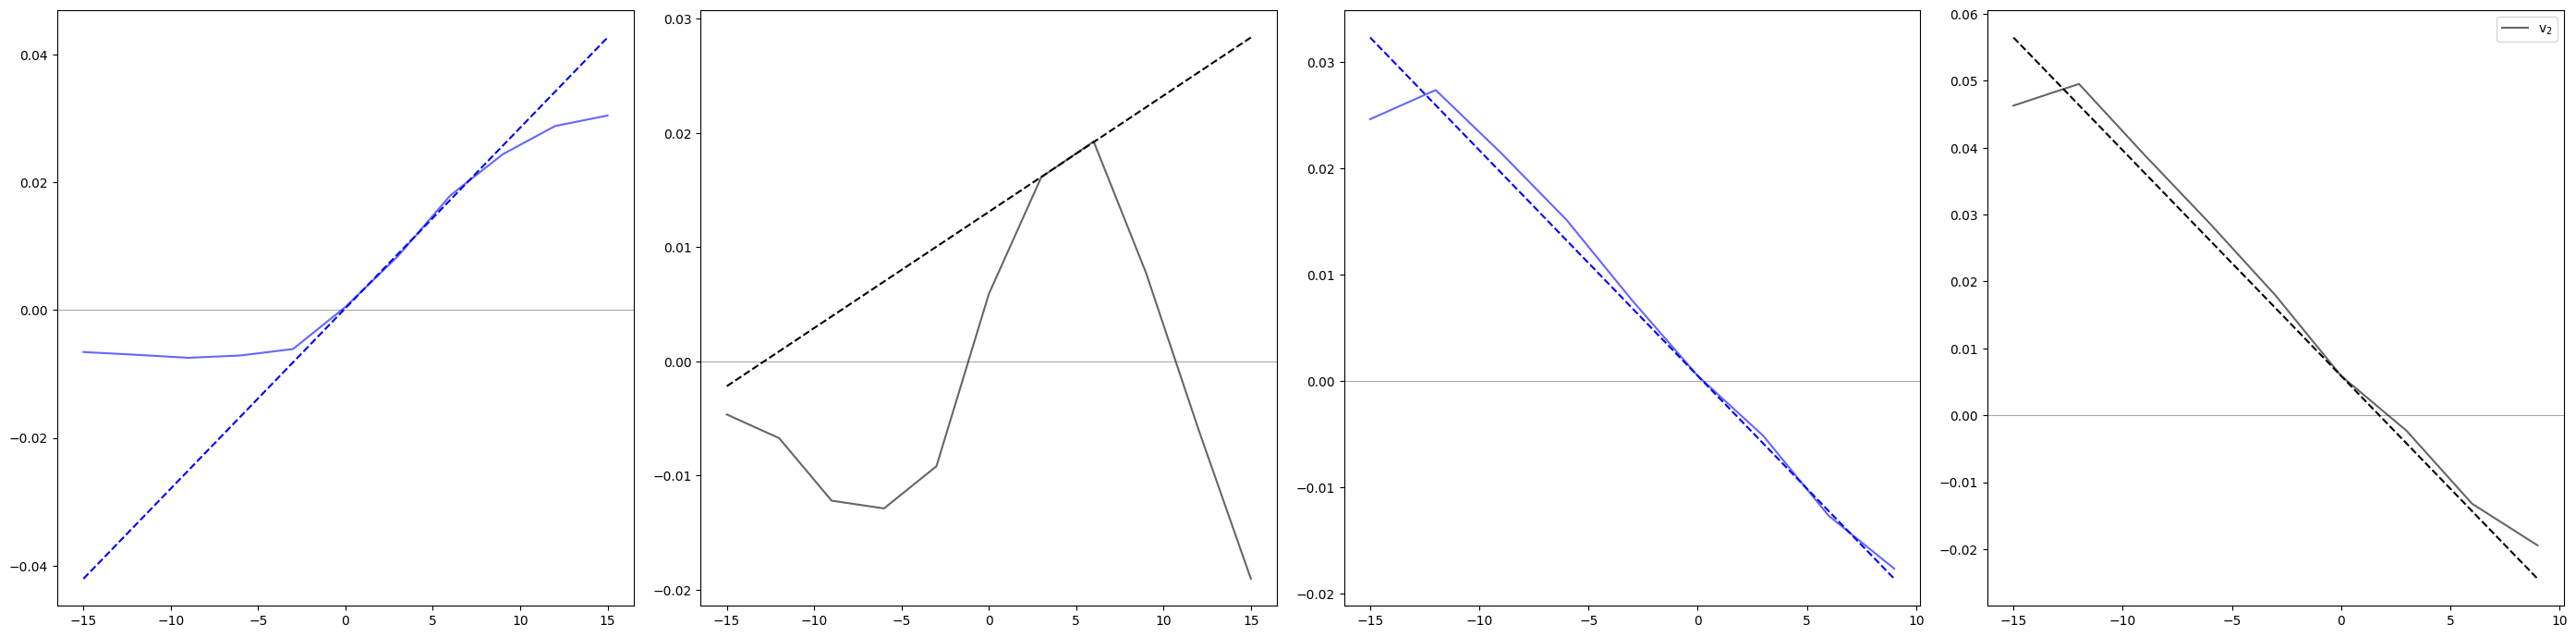

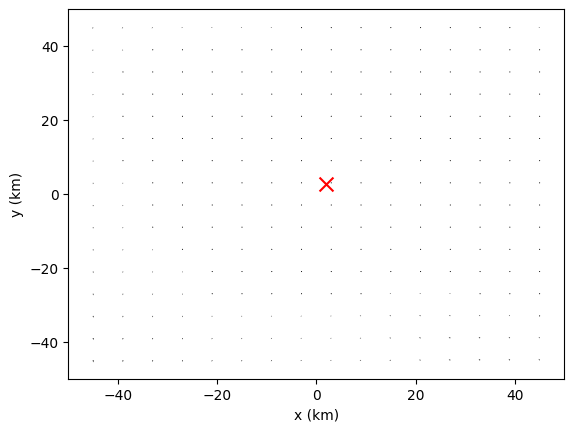

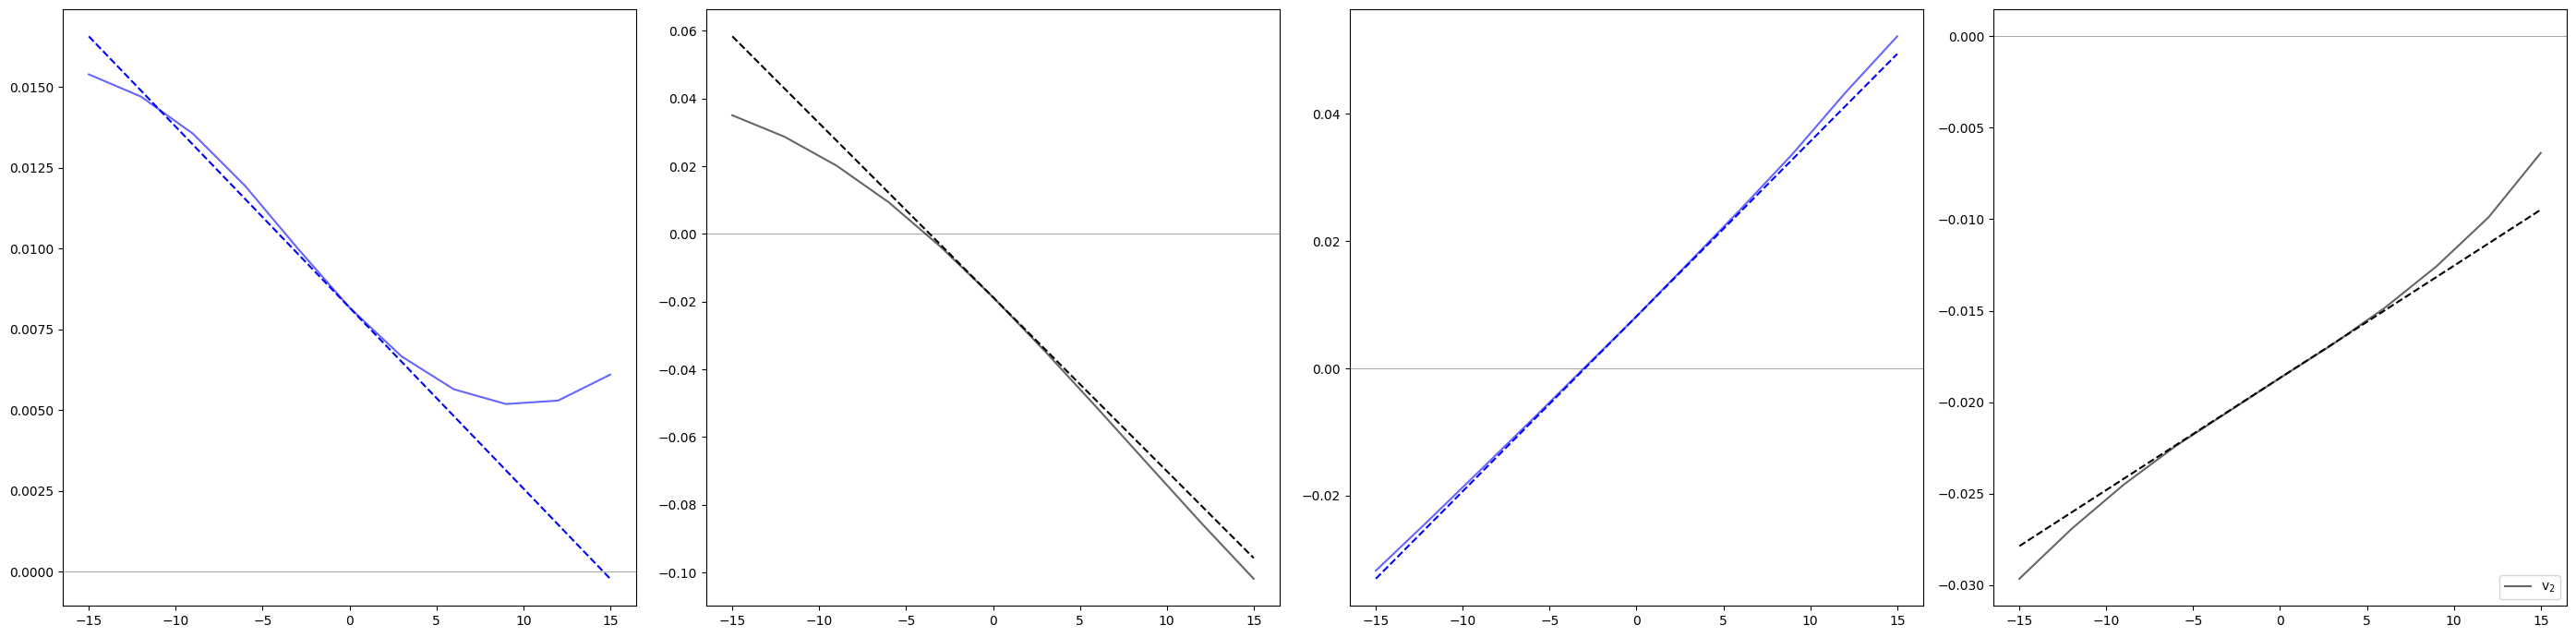

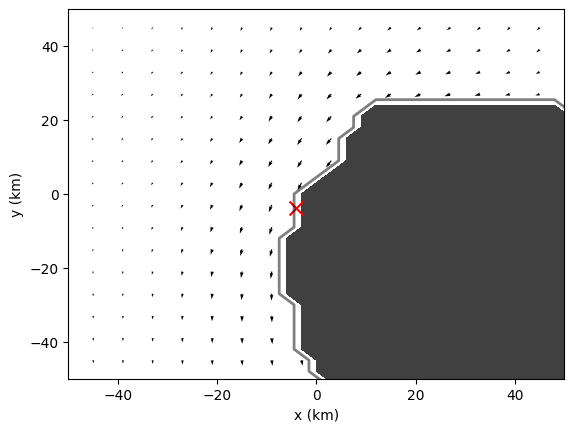

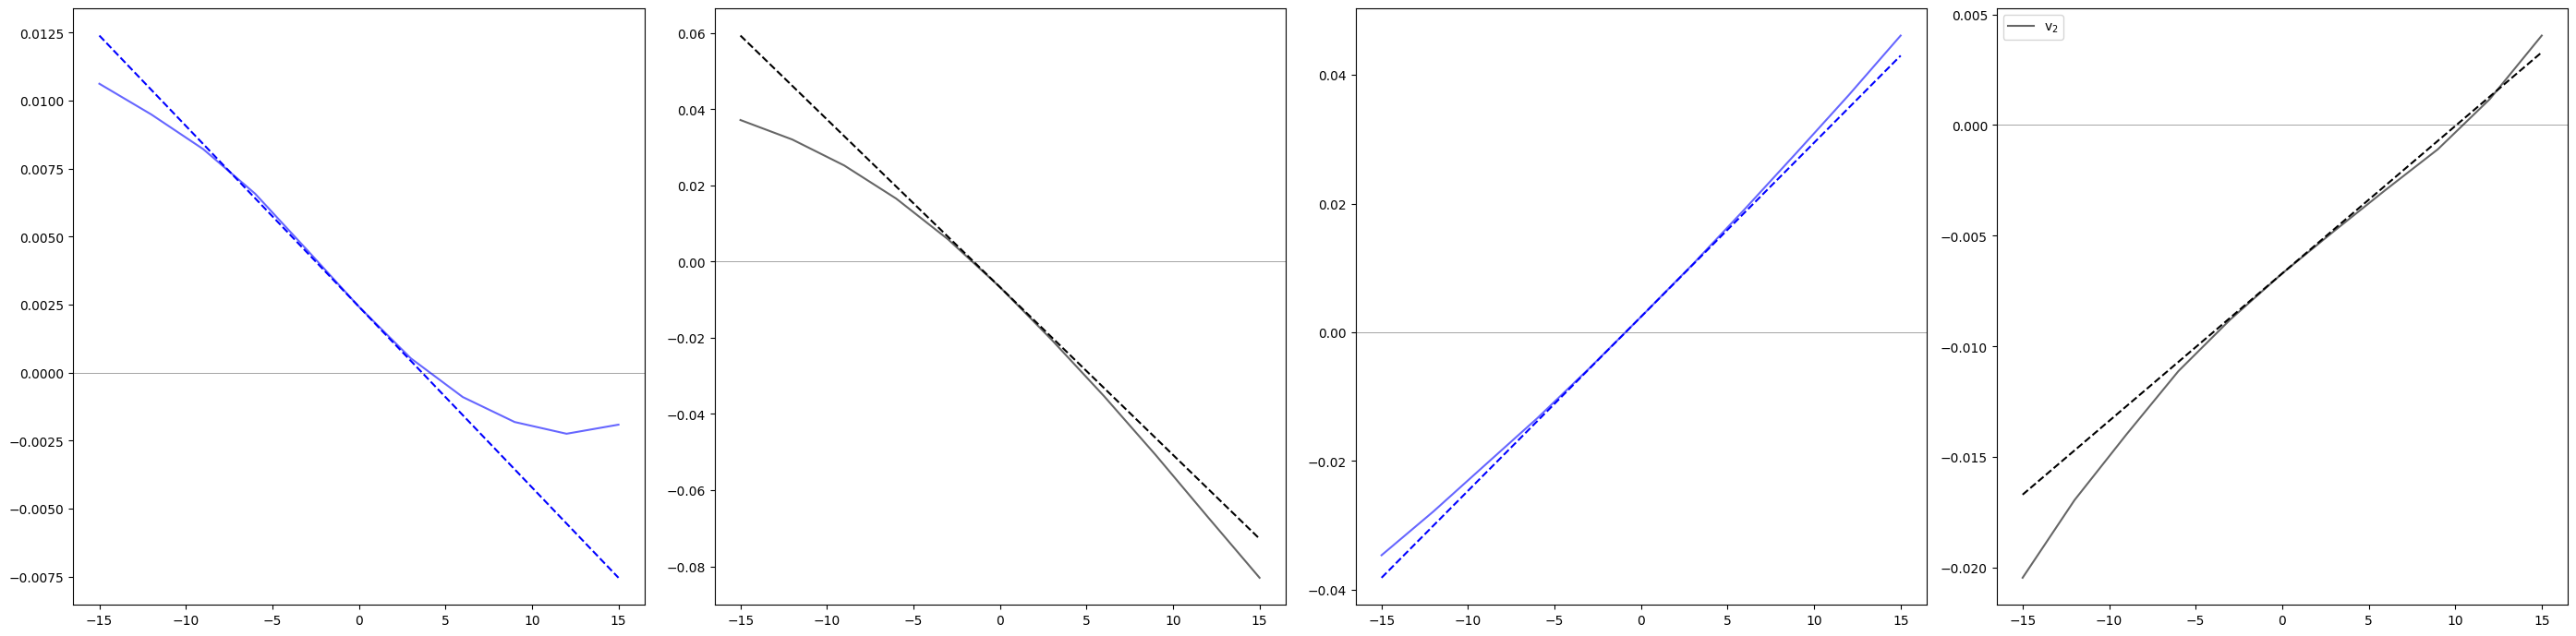

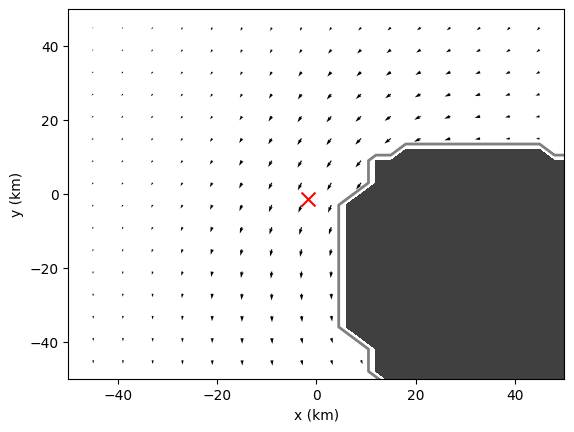

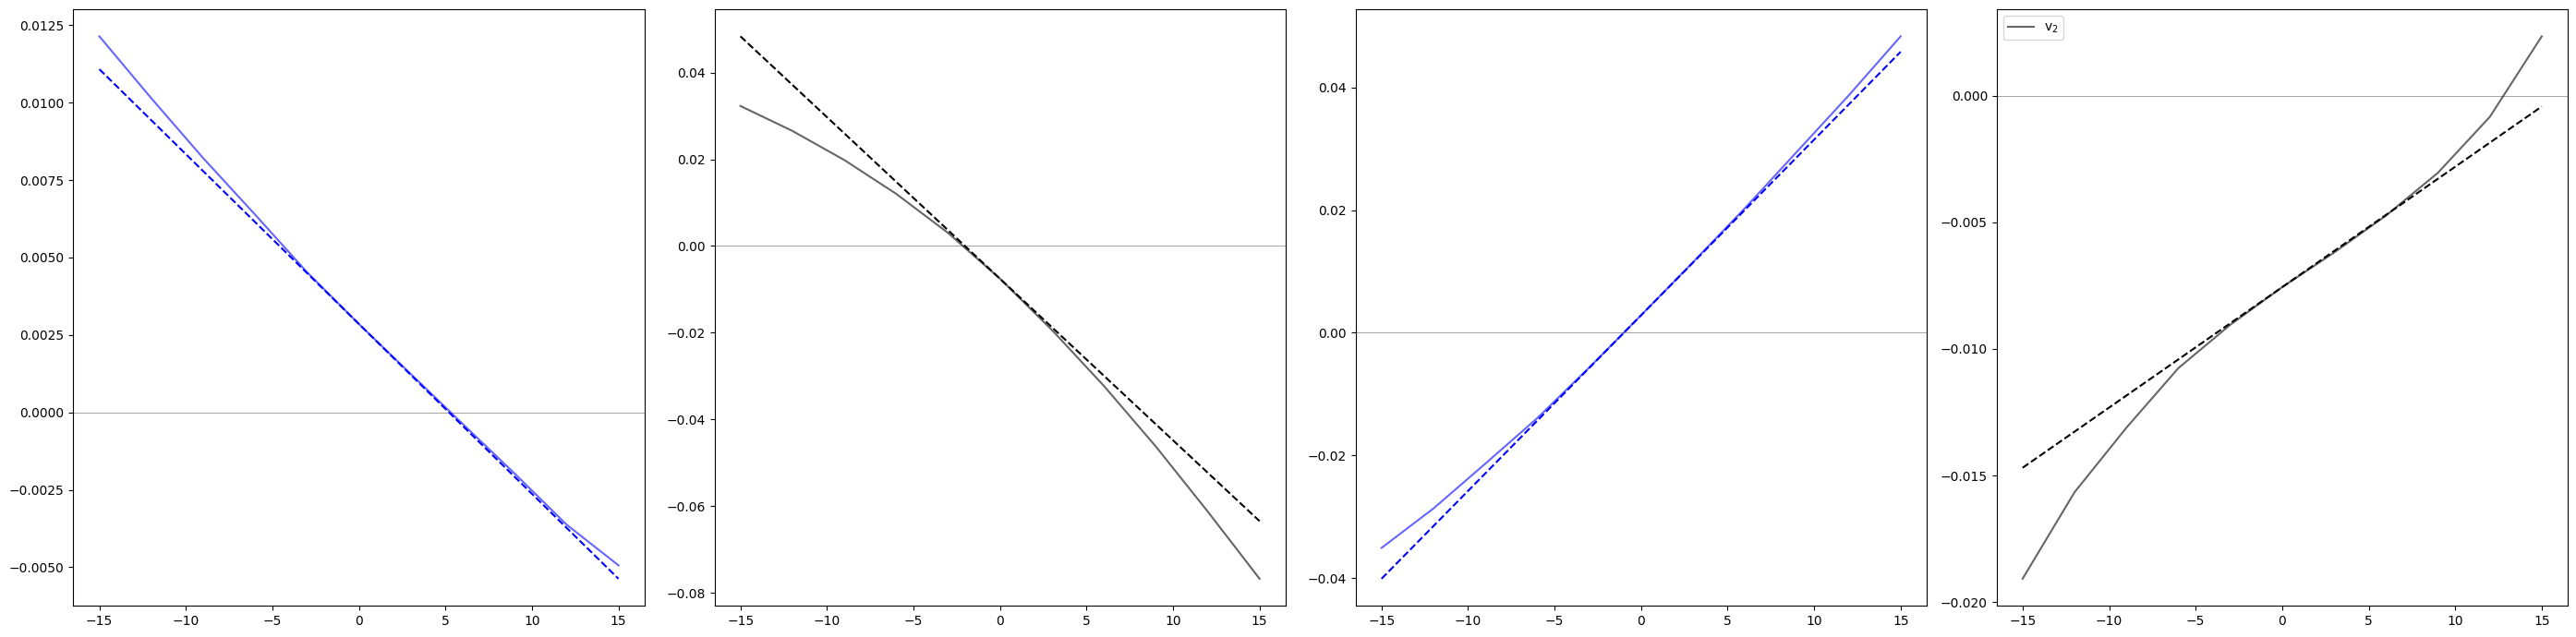

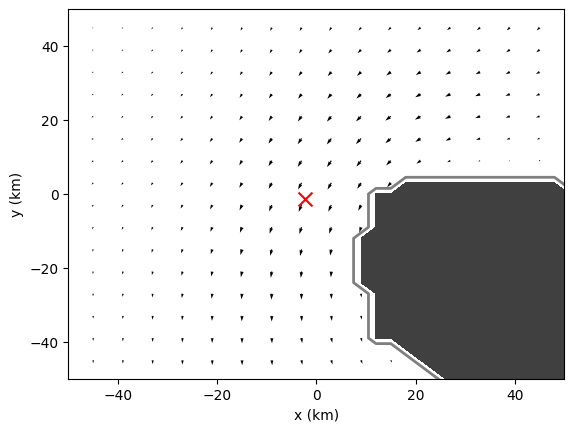

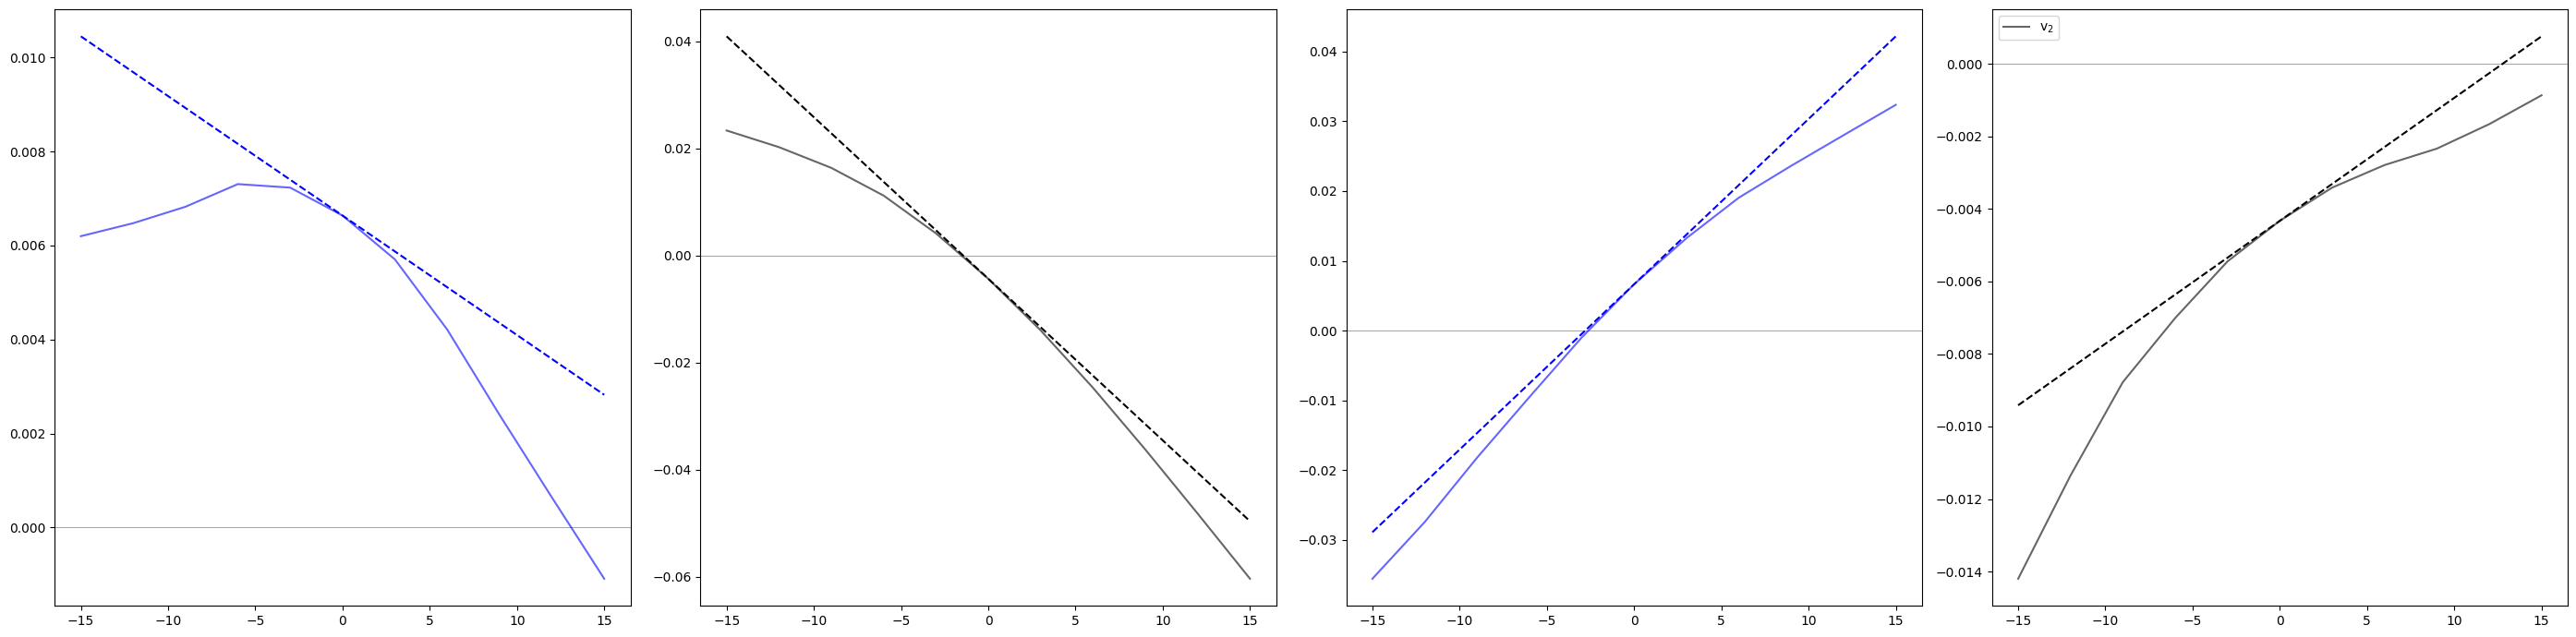

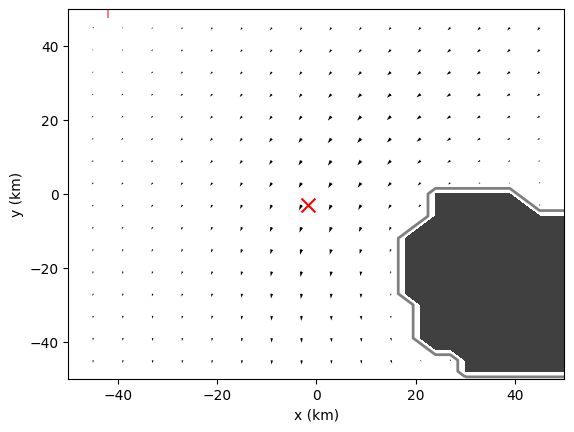

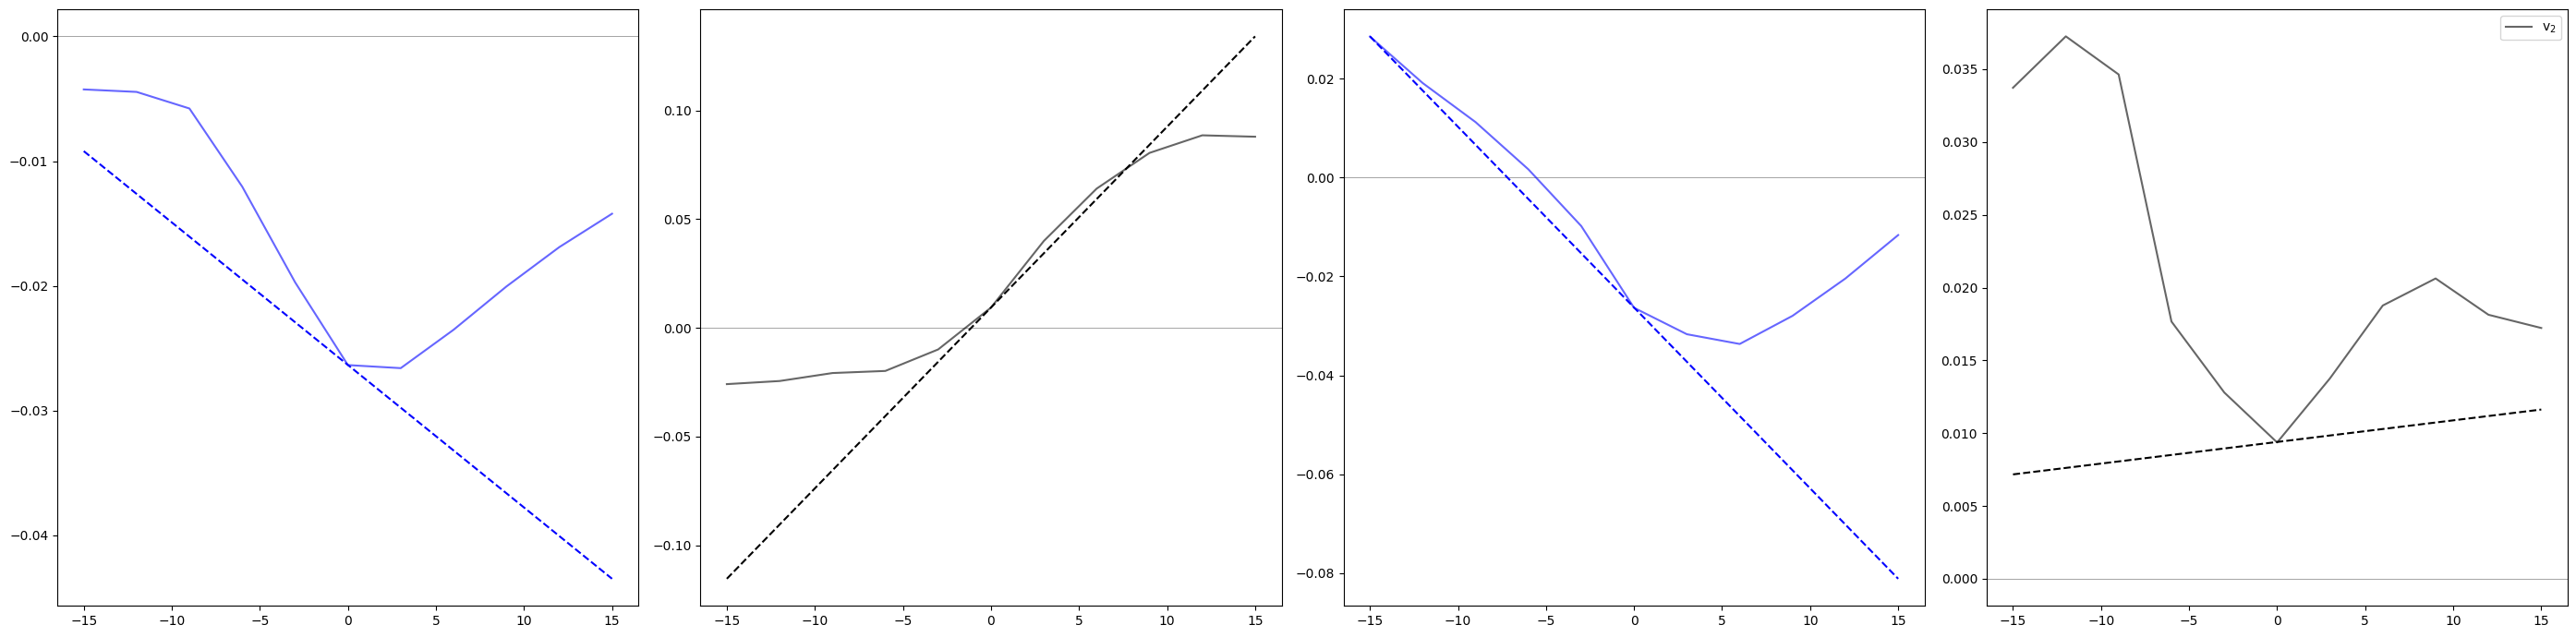

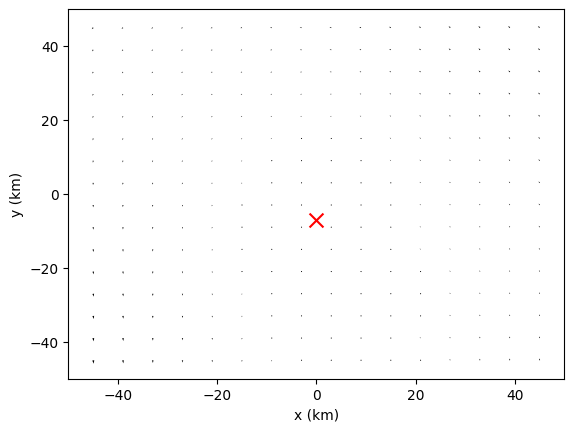

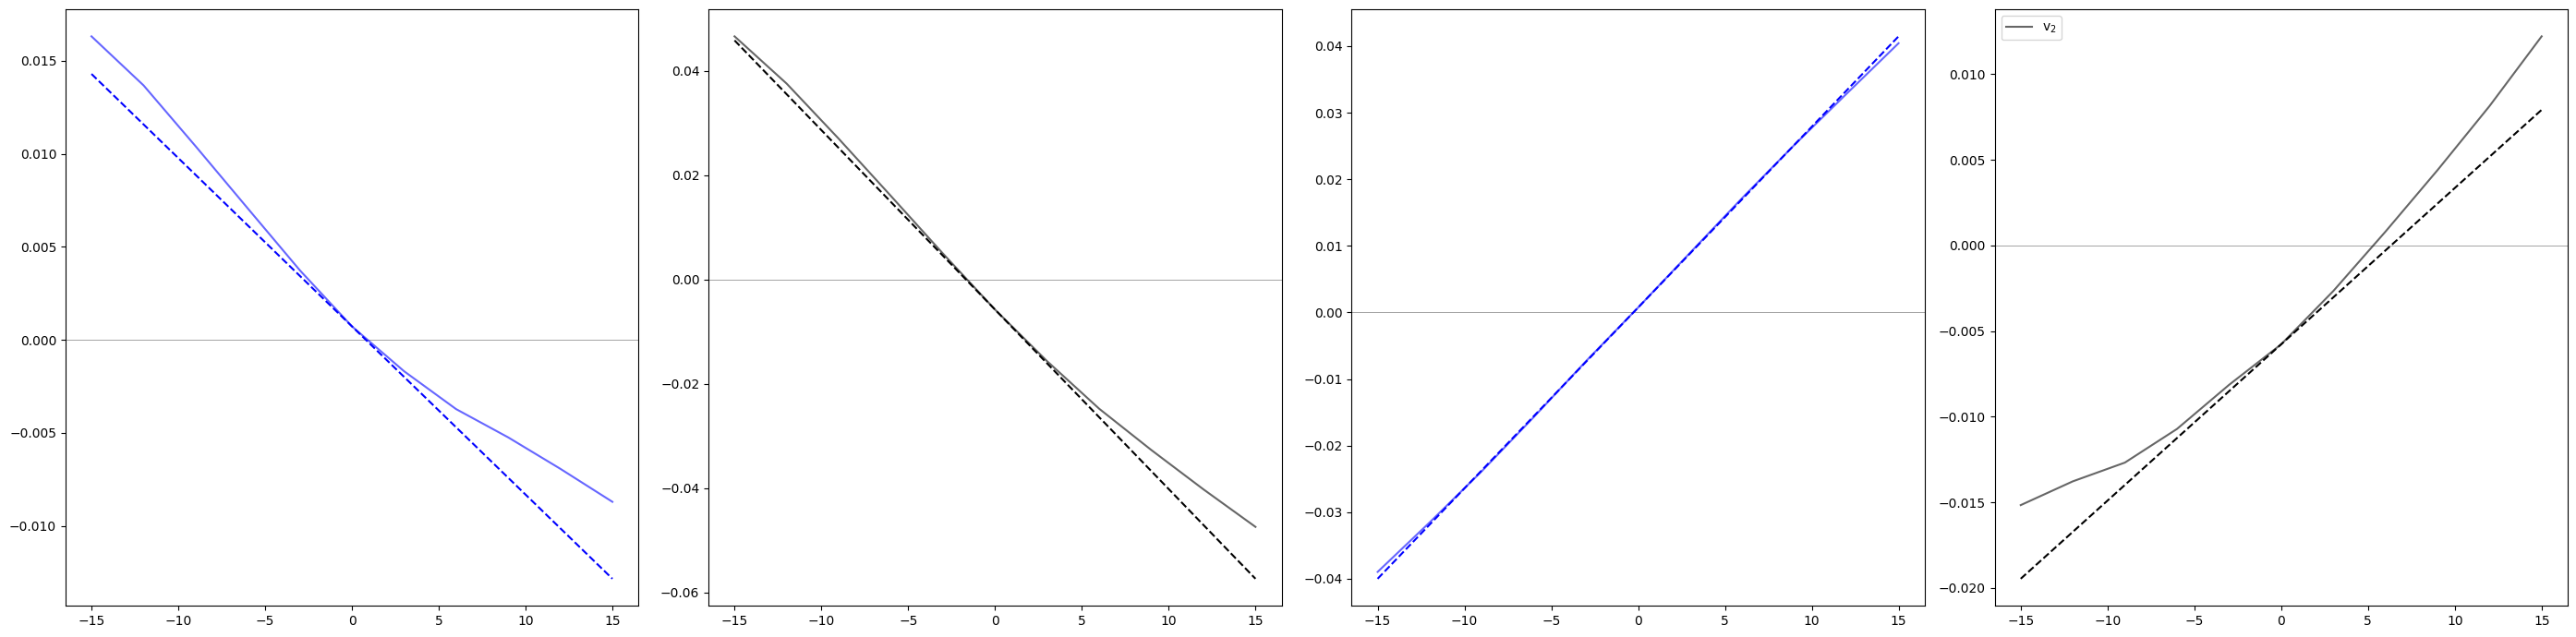

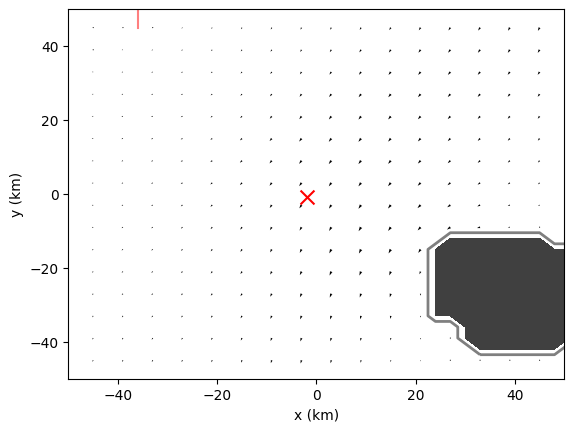

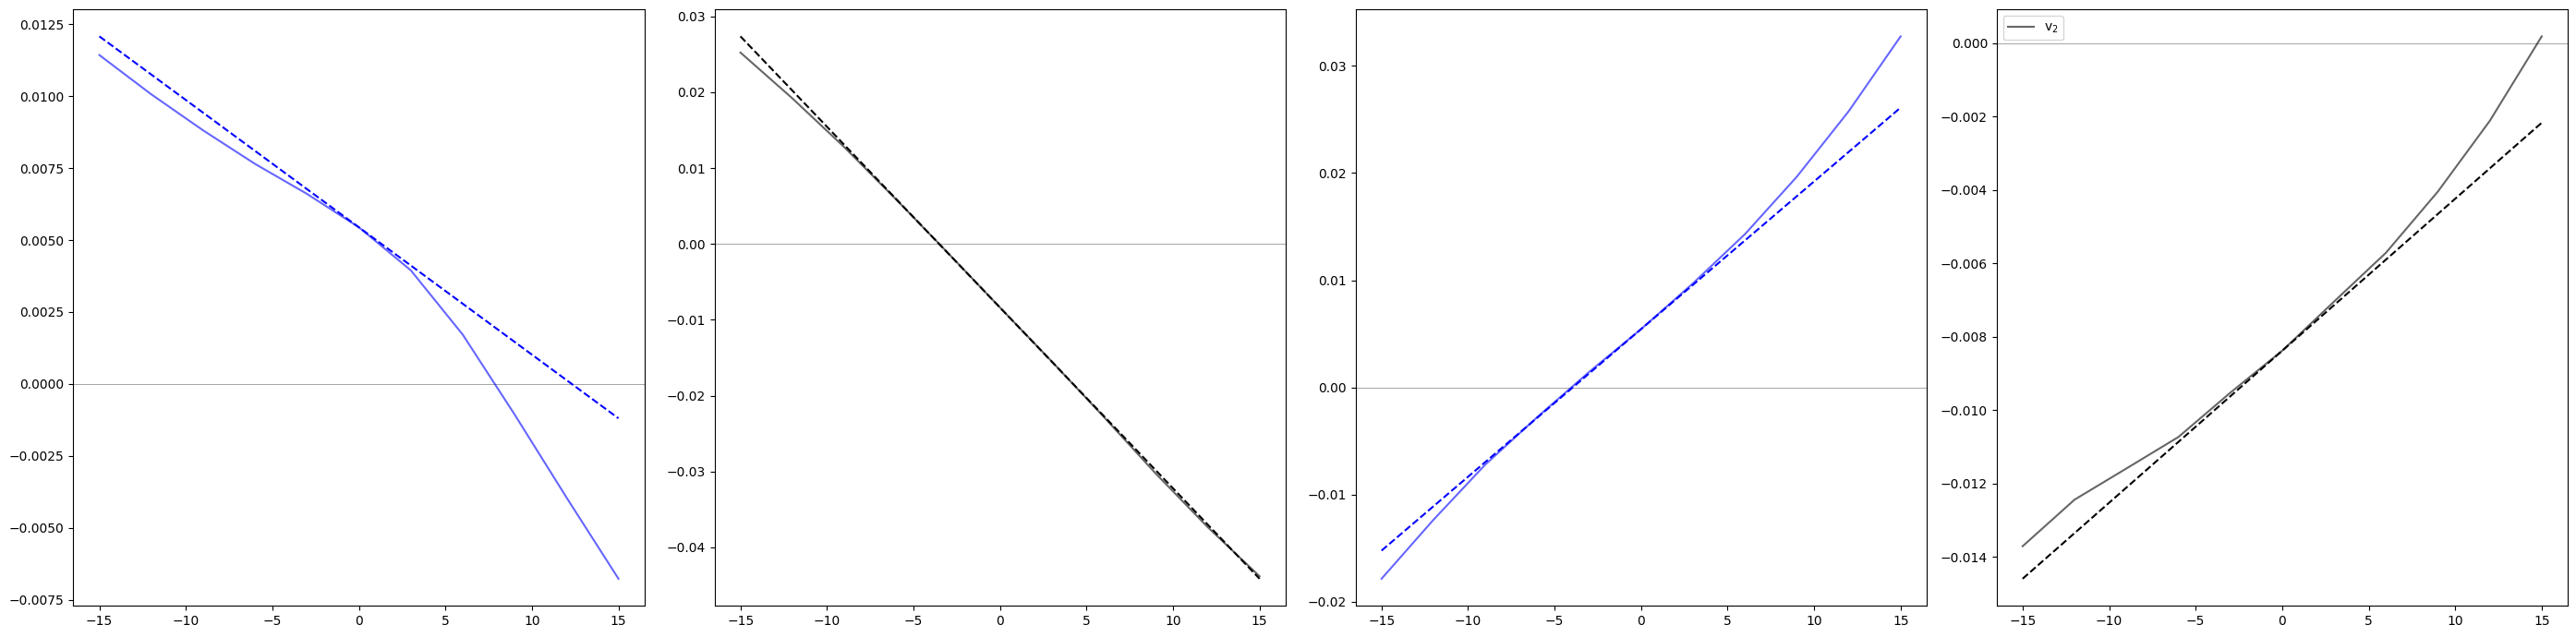

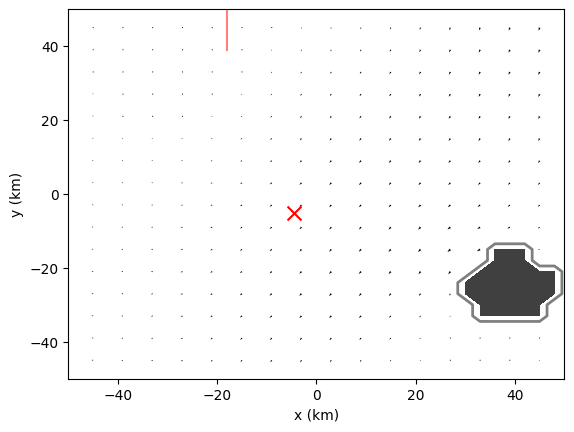

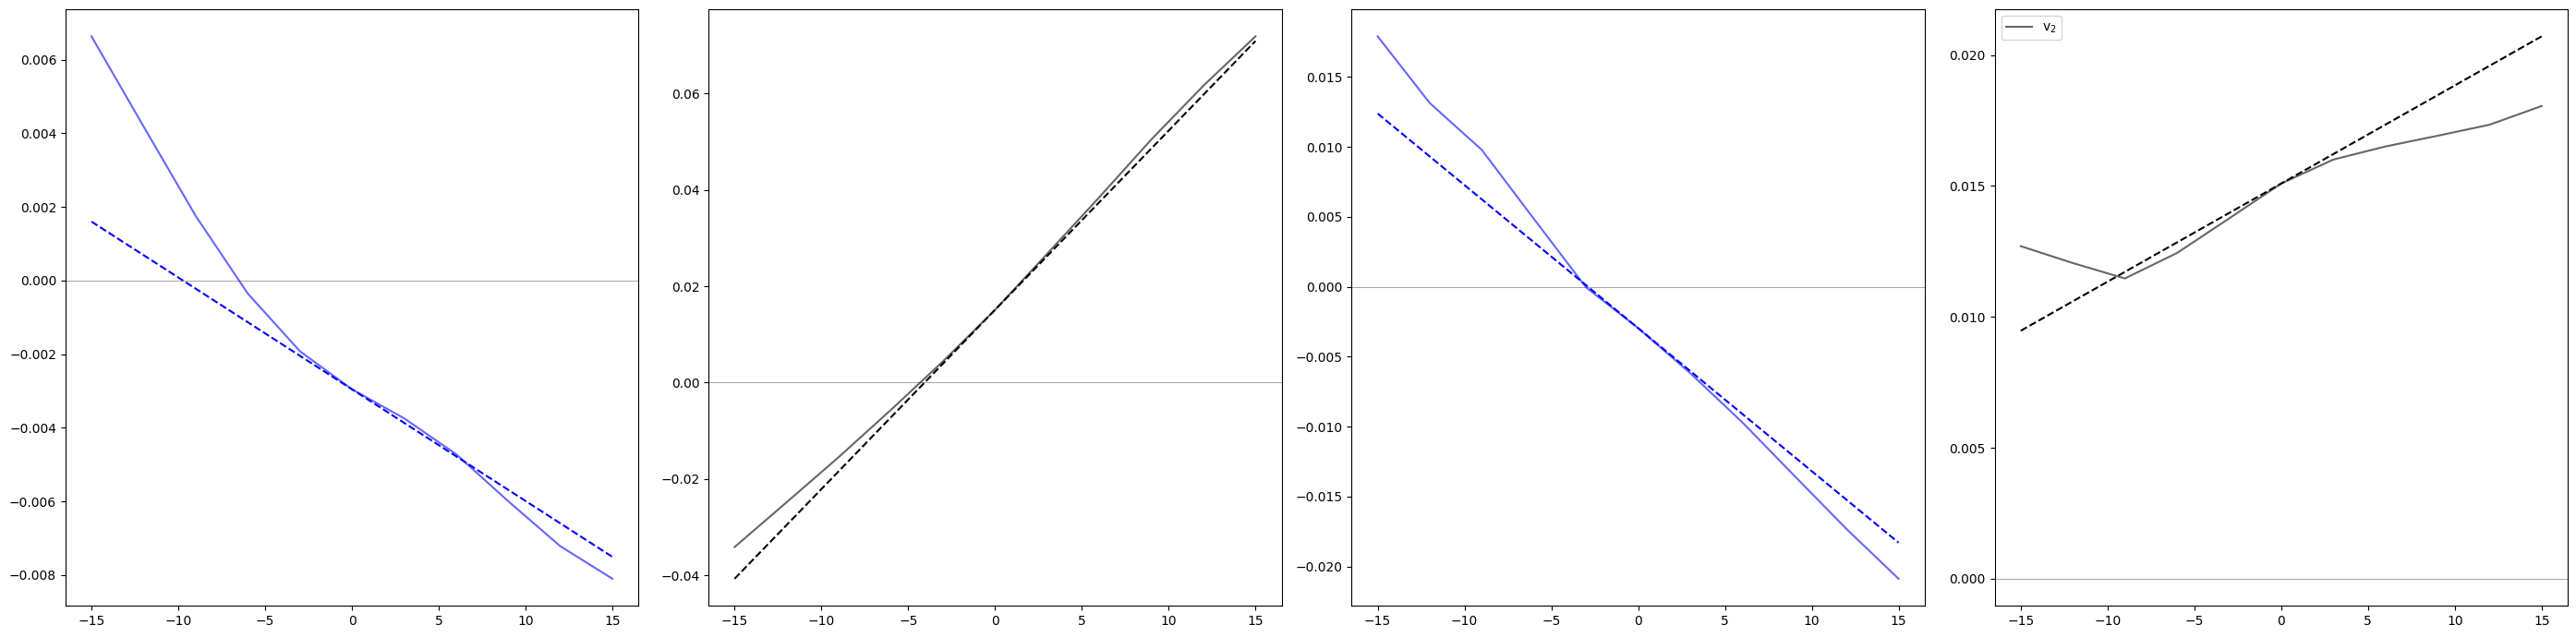

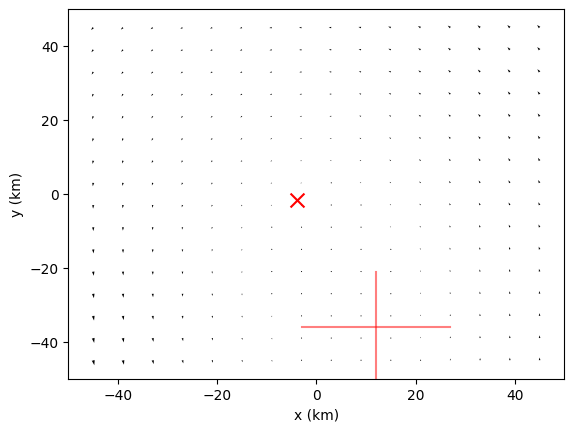

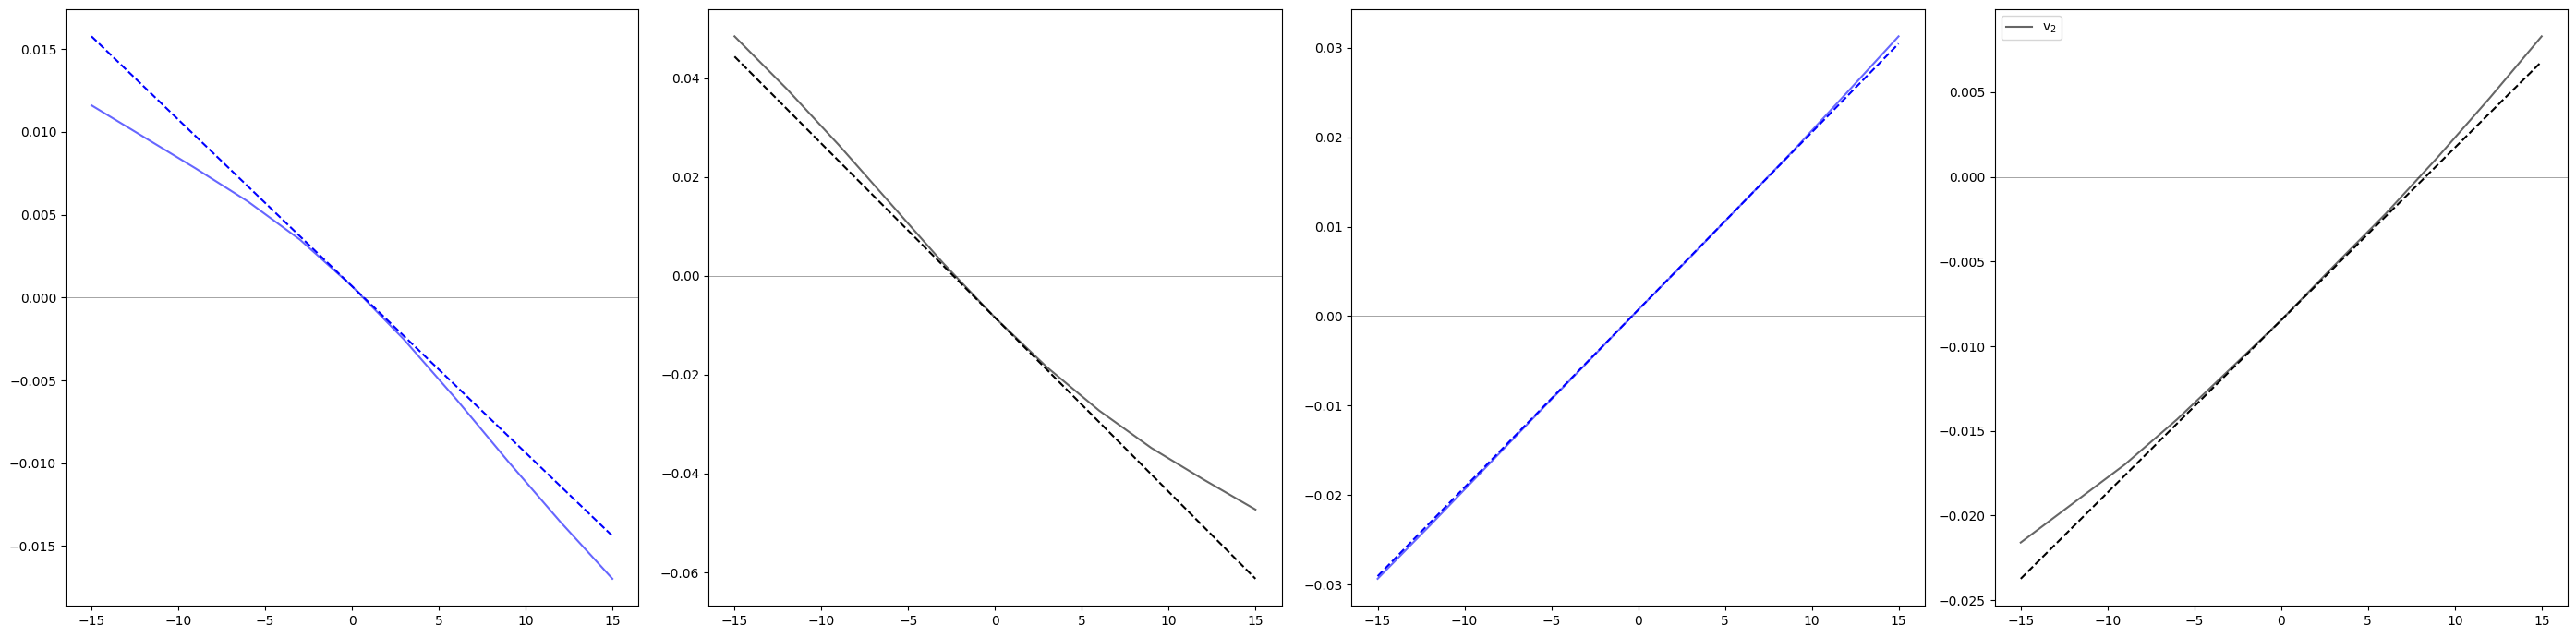

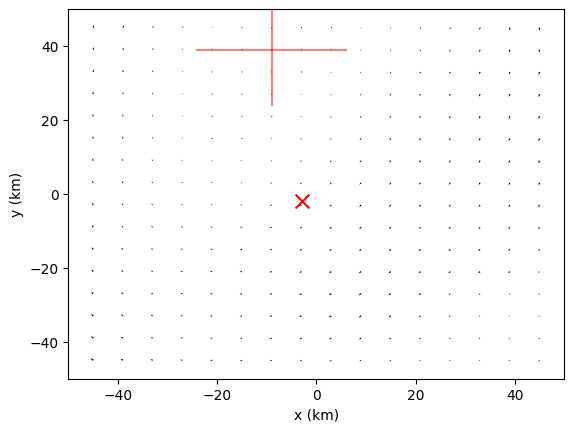

In [22]:
for i in range(len(top_10_worst)):
    eddy = top_10_worst.iloc[i]['Eddy']
    t = top_10_worst.iloc[i]['Day']
    depth_lvl = top_10_worst.iloc[i]['z']

    vis(eddy, t, depth_lvl)

In [23]:
t = 0
filtered_data = result_data[(result_data['Eddy'] == 'Eddy790') & (result_data['Day'] == t)].drop(columns=['Eddy', 'Day']).set_index('z')
filtered_data


nic  njc   nxc   nyc        xc        yc        Depth      Vort  r1  r2  \
z                                                                             
0    51   49   6.0   0.0  1.164294 -0.925069    -1.783320  0.037103 NaN NaN   
1    51   49   6.0   0.0  0.386914  0.156534    -5.879627  0.036906 NaN NaN   
2    51   49   6.0   0.0 -0.167011  0.637369   -10.725783  0.036744 NaN NaN   
3    51   49   6.0   0.0 -0.766120  0.911219   -16.383097  0.036613 NaN NaN   
4    50   49   3.0   0.0  1.550957  0.563185   -22.925581  0.035985 NaN NaN   
5    50   49   3.0   0.0  0.991592  0.437213   -30.444118  0.035747 NaN NaN   
6    50   49   3.0   0.0  0.600461  0.246925   -39.052712  0.035523 NaN NaN   
7    50   49   3.0   0.0  0.381810  0.107126   -48.897638  0.035413 NaN NaN   
8    50   49   3.0   0.0  0.347617  0.106347   -60.170639  0.035359 NaN NaN   
9    50   49   3.0   0.0  0.402995  0.174487   -73.127842  0.034863 NaN NaN   
10   50   49   3.0   0.0  0.359715  0.280256   -88.116838  0.035432 NaN NaN   
11   50   49   3.0   0.0  0.458819  0.026262  -105.615538  0.037634 NaN NaN   
12   50   49   3.0   0.0  0.239336 -0.042175  -126.288127  0.038906 NaN NaN   
13   50   49   3.0   0.0 -0.062641  0.027189  -151.065954  0.036933 NaN NaN   
14   50   49   3.0   0.0 -0.186804  0.067406  -181.264793  0.035979 NaN NaN   
15   50   49   3.0   0.0 -0.241500  0.154440  -218.754856  0.035532 NaN NaN   
16   50   49   3.0   0.0 -0.324981  0.263828  -266.206398  0.034716 NaN NaN   
17   50   49   3.0   0.0 -0.241203  0.597092  -327.440851  0.033997 NaN NaN   
18   50   49   3.0   0.0  0.576509  1.242308  -407.922192  0.028046 NaN NaN   
19   51   50   6.0   3.0 -1.238422 -0.003059  -515.416489  0.019604 NaN NaN   
20   50   51   3.0   6.0  1.100699 -0.991895  -660.806374  0.014611 NaN NaN   
21   50   52   3.0   9.0  1.374176  1.298740  -858.918478  0.010540 NaN NaN   
22   52   53   9.0  12.0  0.541283  1.385657 -1128.898331  0.007726 NaN NaN   
23   53   55  12.0  18.0 -0.101747  0.911810 -1492.971178  0.005940 NaN NaN   
24   54   59  15.0  30.0 -0.397905  0.057556 -1971.212518  0.003265 NaN NaN   

    r3  r4  
z           
0  NaN NaN  
1  NaN NaN  
2  NaN NaN  
3  NaN NaN  
4  NaN NaN  
5  NaN NaN  
6  NaN NaN  
7  NaN NaN  
8  NaN NaN  
9  NaN NaN  
10 NaN NaN  
11 NaN NaN  
12 NaN NaN  
13 NaN NaN  
14 NaN NaN  
15 NaN NaN  
16 NaN NaN  
17 NaN NaN  
18 NaN NaN  
19 NaN NaN  
20 NaN NaN  
21 NaN NaN  
22 NaN NaN  
23 NaN NaN  
24 NaN NaN

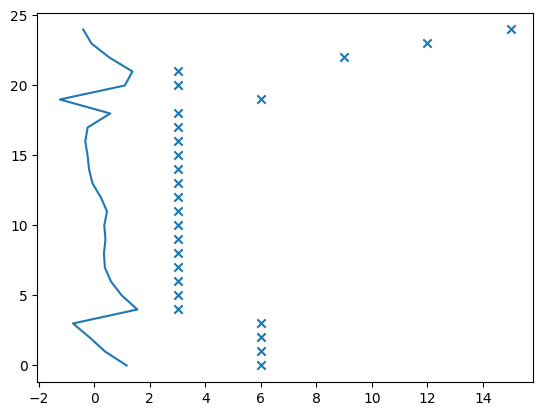

In [24]:
plt.scatter(filtered_data['nxc'], filtered_data.index, marker='x')
plt.plot(filtered_data['xc'], filtered_data.index)

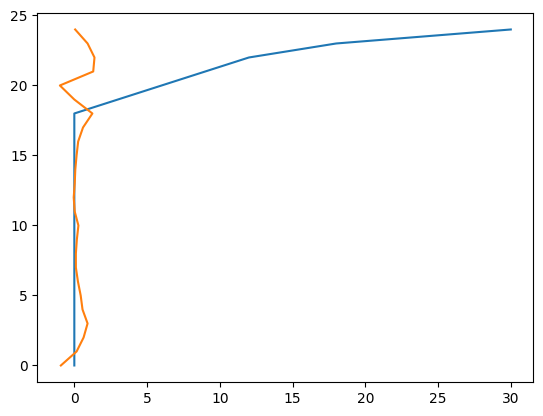

In [25]:
plt.plot(filtered_data['nyc'], filtered_data.index)
plt.plot(filtered_data['yc'], filtered_data.index)

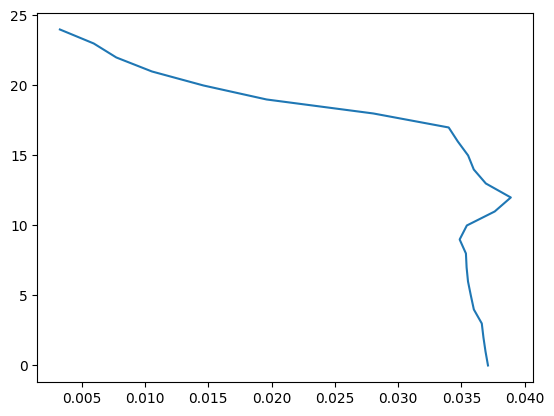

In [26]:
plt.plot(filtered_data['Vort'], filtered_data.index)

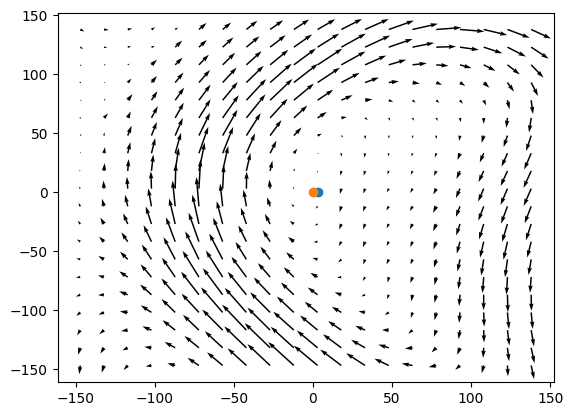

In [27]:
U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']

depth_lvl = 10

u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

data = filtered_data.loc[depth_lvl]

spacing = 5
plt.quiver(x[::spacing]/1000, y[::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)
plt.scatter(data['nxc'], data['nyc'])
plt.scatter(data['xc'], data['yc'])

In [28]:
filtered_data

nic  njc   nxc   nyc        xc        yc        Depth      Vort  r1  r2  \
z                                                                             
0    51   49   6.0   0.0  1.164294 -0.925069    -1.783320  0.037103 NaN NaN   
1    51   49   6.0   0.0  0.386914  0.156534    -5.879627  0.036906 NaN NaN   
2    51   49   6.0   0.0 -0.167011  0.637369   -10.725783  0.036744 NaN NaN   
3    51   49   6.0   0.0 -0.766120  0.911219   -16.383097  0.036613 NaN NaN   
4    50   49   3.0   0.0  1.550957  0.563185   -22.925581  0.035985 NaN NaN   
5    50   49   3.0   0.0  0.991592  0.437213   -30.444118  0.035747 NaN NaN   
6    50   49   3.0   0.0  0.600461  0.246925   -39.052712  0.035523 NaN NaN   
7    50   49   3.0   0.0  0.381810  0.107126   -48.897638  0.035413 NaN NaN   
8    50   49   3.0   0.0  0.347617  0.106347   -60.170639  0.035359 NaN NaN   
9    50   49   3.0   0.0  0.402995  0.174487   -73.127842  0.034863 NaN NaN   
10   50   49   3.0   0.0  0.359715  0.280256   -88.116838  0.035432 NaN NaN   
11   50   49   3.0   0.0  0.458819  0.026262  -105.615538  0.037634 NaN NaN   
12   50   49   3.0   0.0  0.239336 -0.042175  -126.288127  0.038906 NaN NaN   
13   50   49   3.0   0.0 -0.062641  0.027189  -151.065954  0.036933 NaN NaN   
14   50   49   3.0   0.0 -0.186804  0.067406  -181.264793  0.035979 NaN NaN   
15   50   49   3.0   0.0 -0.241500  0.154440  -218.754856  0.035532 NaN NaN   
16   50   49   3.0   0.0 -0.324981  0.263828  -266.206398  0.034716 NaN NaN   
17   50   49   3.0   0.0 -0.241203  0.597092  -327.440851  0.033997 NaN NaN   
18   50   49   3.0   0.0  0.576509  1.242308  -407.922192  0.028046 NaN NaN   
19   51   50   6.0   3.0 -1.238422 -0.003059  -515.416489  0.019604 NaN NaN   
20   50   51   3.0   6.0  1.100699 -0.991895  -660.806374  0.014611 NaN NaN   
21   50   52   3.0   9.0  1.374176  1.298740  -858.918478  0.010540 NaN NaN   
22   52   53   9.0  12.0  0.541283  1.385657 -1128.898331  0.007726 NaN NaN   
23   53   55  12.0  18.0 -0.101747  0.911810 -1492.971178  0.005940 NaN NaN   
24   54   59  15.0  30.0 -0.397905  0.057556 -1971.212518  0.003265 NaN NaN   

    r3  r4  
z           
0  NaN NaN  
1  NaN NaN  
2  NaN NaN  
3  NaN NaN  
4  NaN NaN  
5  NaN NaN  
6  NaN NaN  
7  NaN NaN  
8  NaN NaN  
9  NaN NaN  
10 NaN NaN  
11 NaN NaN  
12 NaN NaN  
13 NaN NaN  
14 NaN NaN  
15 NaN NaN  
16 NaN NaN  
17 NaN NaN  
18 NaN NaN  
19 NaN NaN  
20 NaN NaN  
21 NaN NaN  
22 NaN NaN  
23 NaN NaN  
24 NaN NaN